In [28]:
import numpy as np
from scipy.optimize import curve_fit
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [ ]:
SAVE_FILE = False

In [29]:
summary_statistics = pd.DataFrame()
# Add columns for SSE1 and SSE2
summary_statistics['SSE1'] = np.nan
summary_statistics['SSE2'] = np.nan

In [30]:
tasks = [
    "square_D1",
    "nut_assembly_D0",
    "three_piece_assembly_D1",
    "kitchen_D1",
    "coffee_D1",
    "stack_three_D1",
    "stack_D0", # Outlier alert!! Try other D0 tasks.
    "hammer_cleanup_D0",
    "pick_place_D0",
    "coffee_preparation_D1",
    "Cumulative_Data",
]
trial_count = 30

Parameters for task square_D1: [-45.83135873   0.97421068  11.32216409  -2.71064877]
Performance with 0 noise: 42
SSE: 267.62280160734076


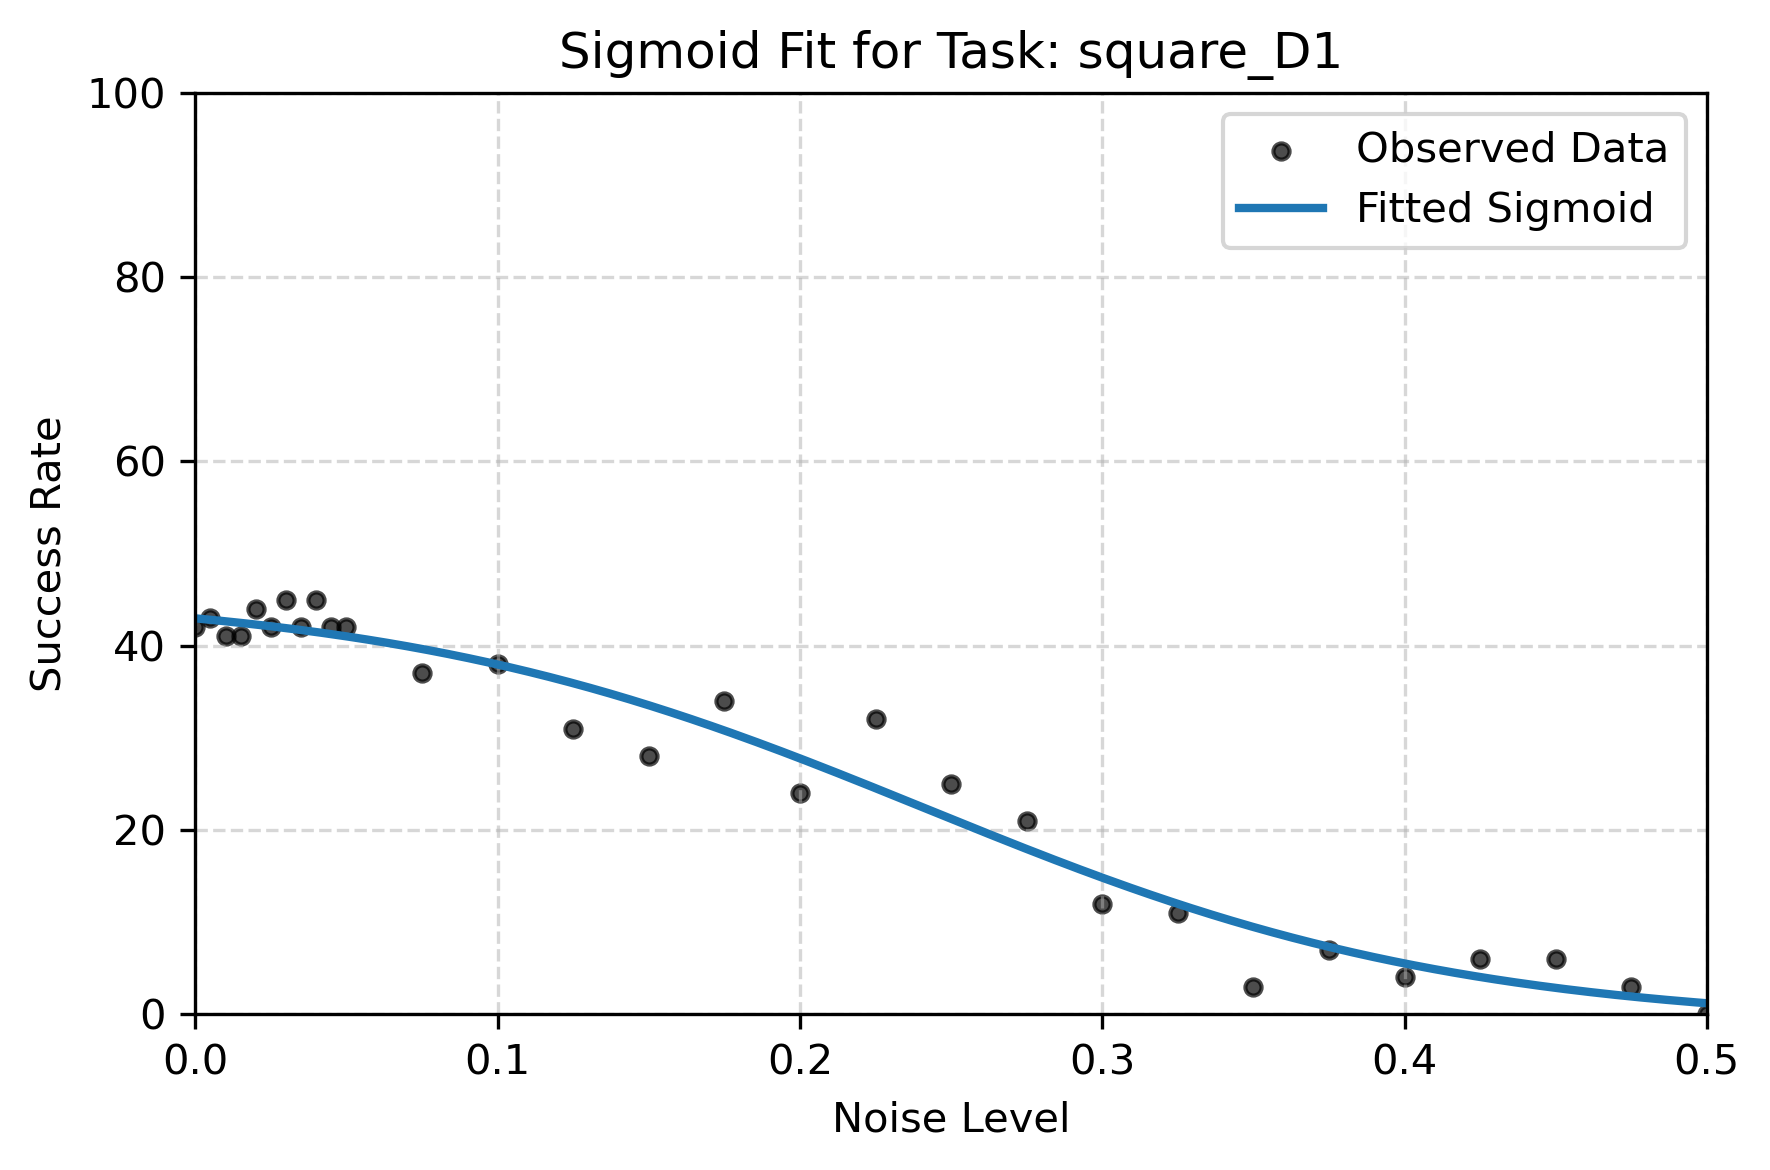

Parameters for task nut_assembly_D0: [-54.75704451   1.00332824  20.30502194  -3.62992183]
Performance with 0 noise: 53
SSE: 279.67001179611674


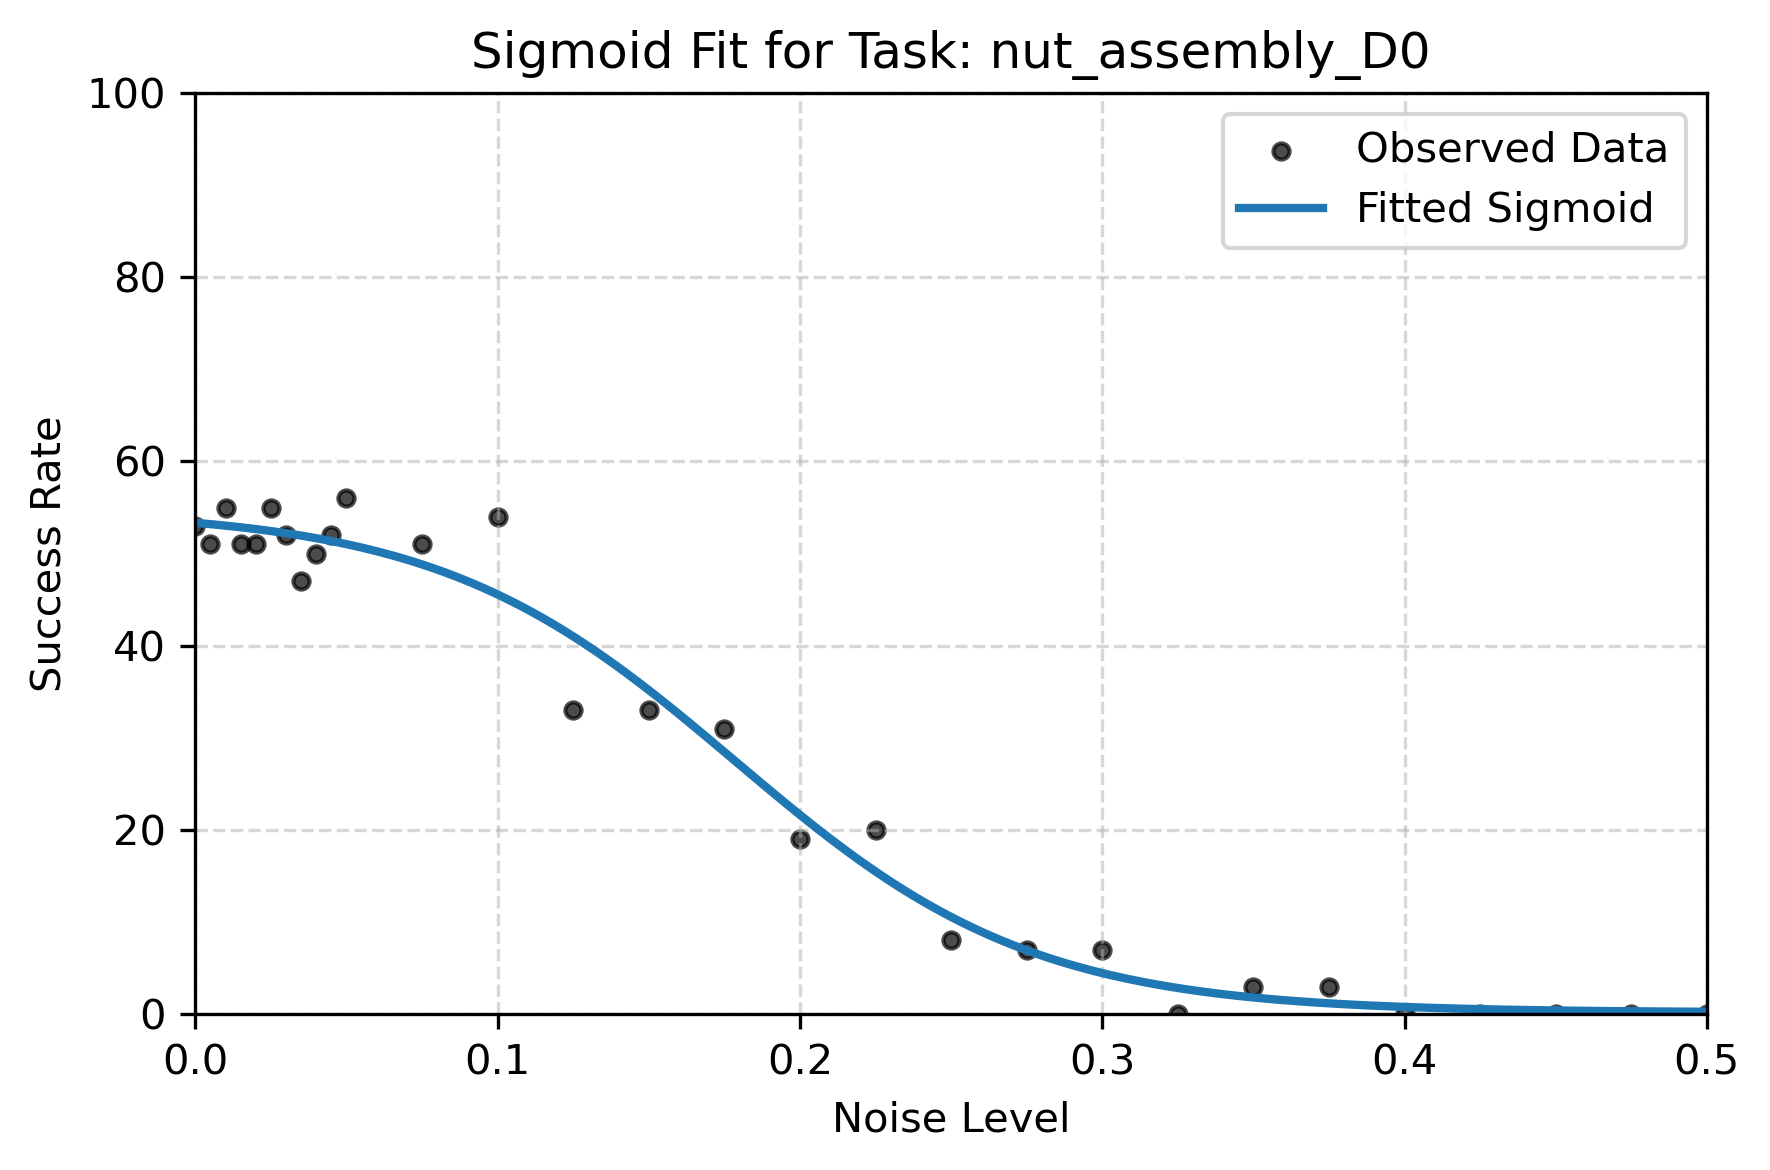

Parameters for task three_piece_assembly_D1: [-26.30720954   1.02556998  19.2958359   -3.43661591]
Performance with 0 noise: 23
SSE: 145.06772798224358


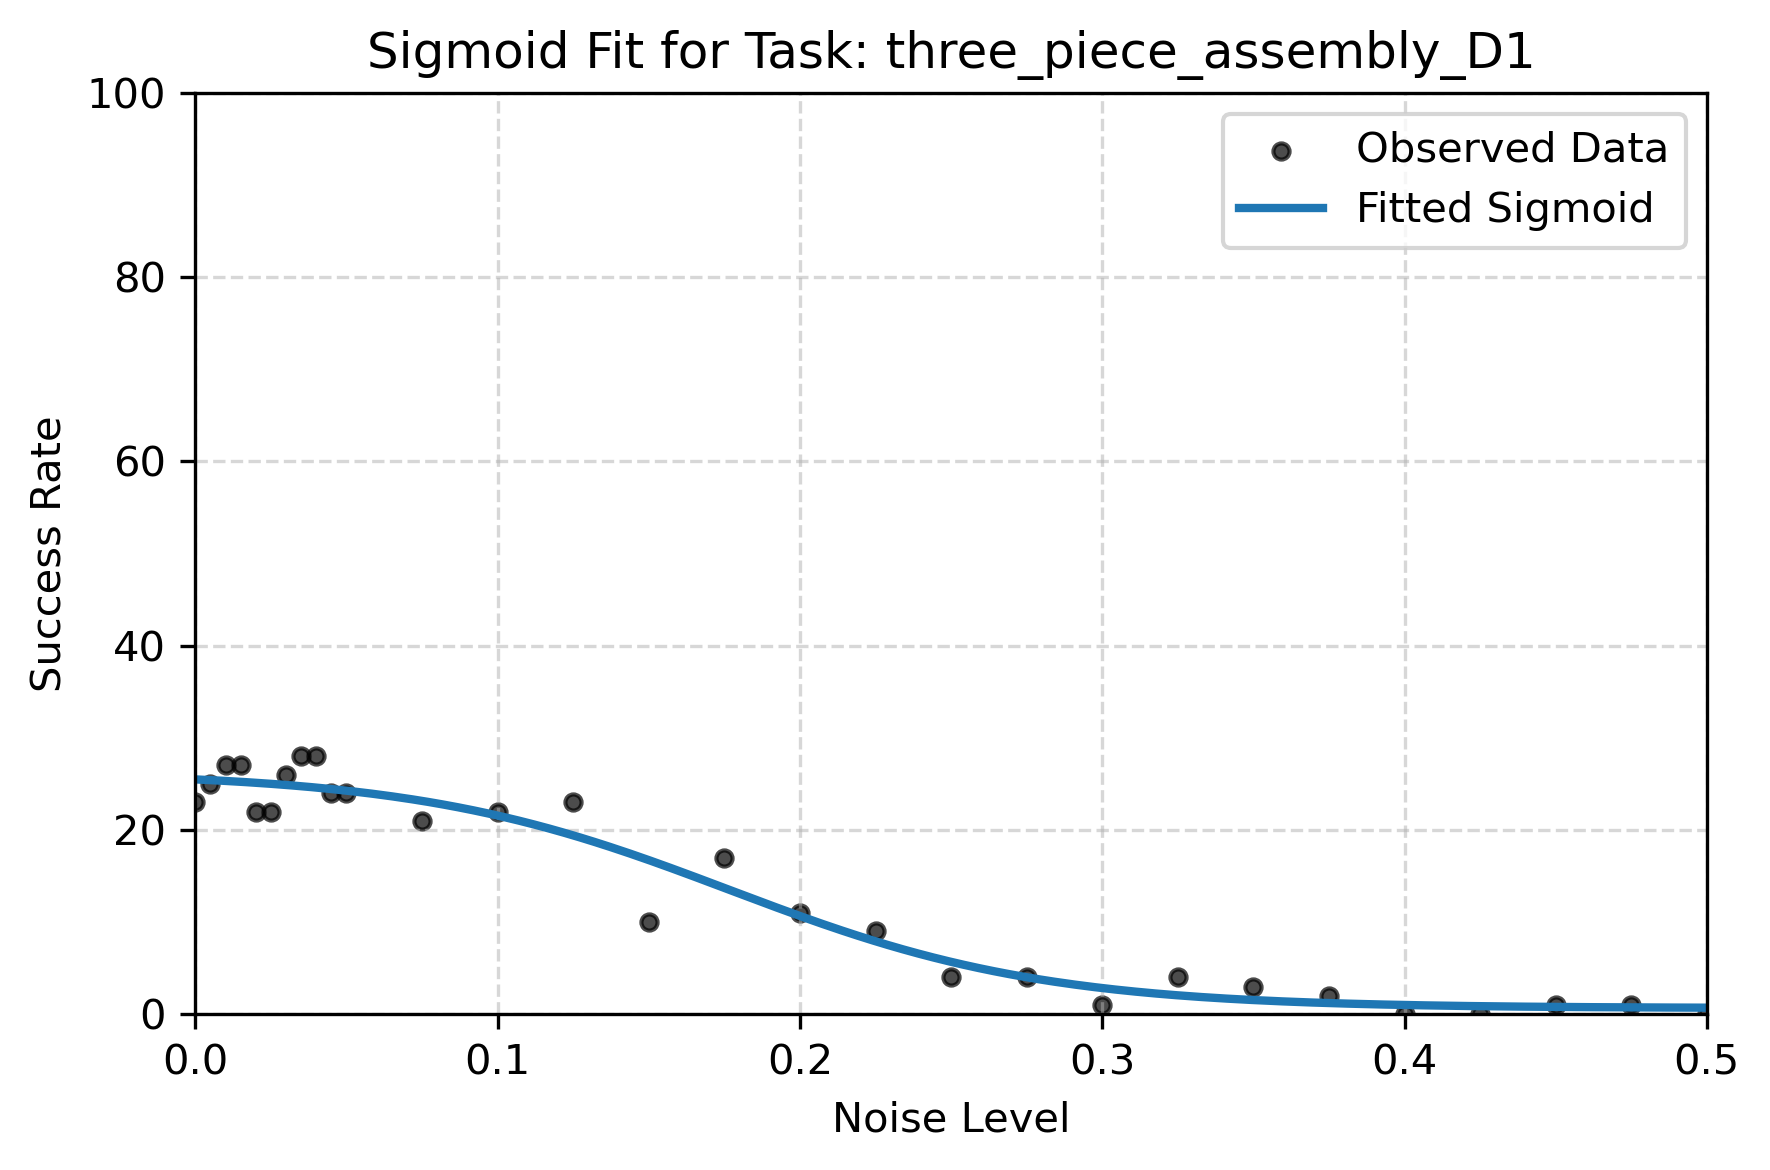

Parameters for task kitchen_D1: [-53.08434461   0.99533897  16.50924791  -3.33916615]
Performance with 0 noise: 52
SSE: 361.9060331874671


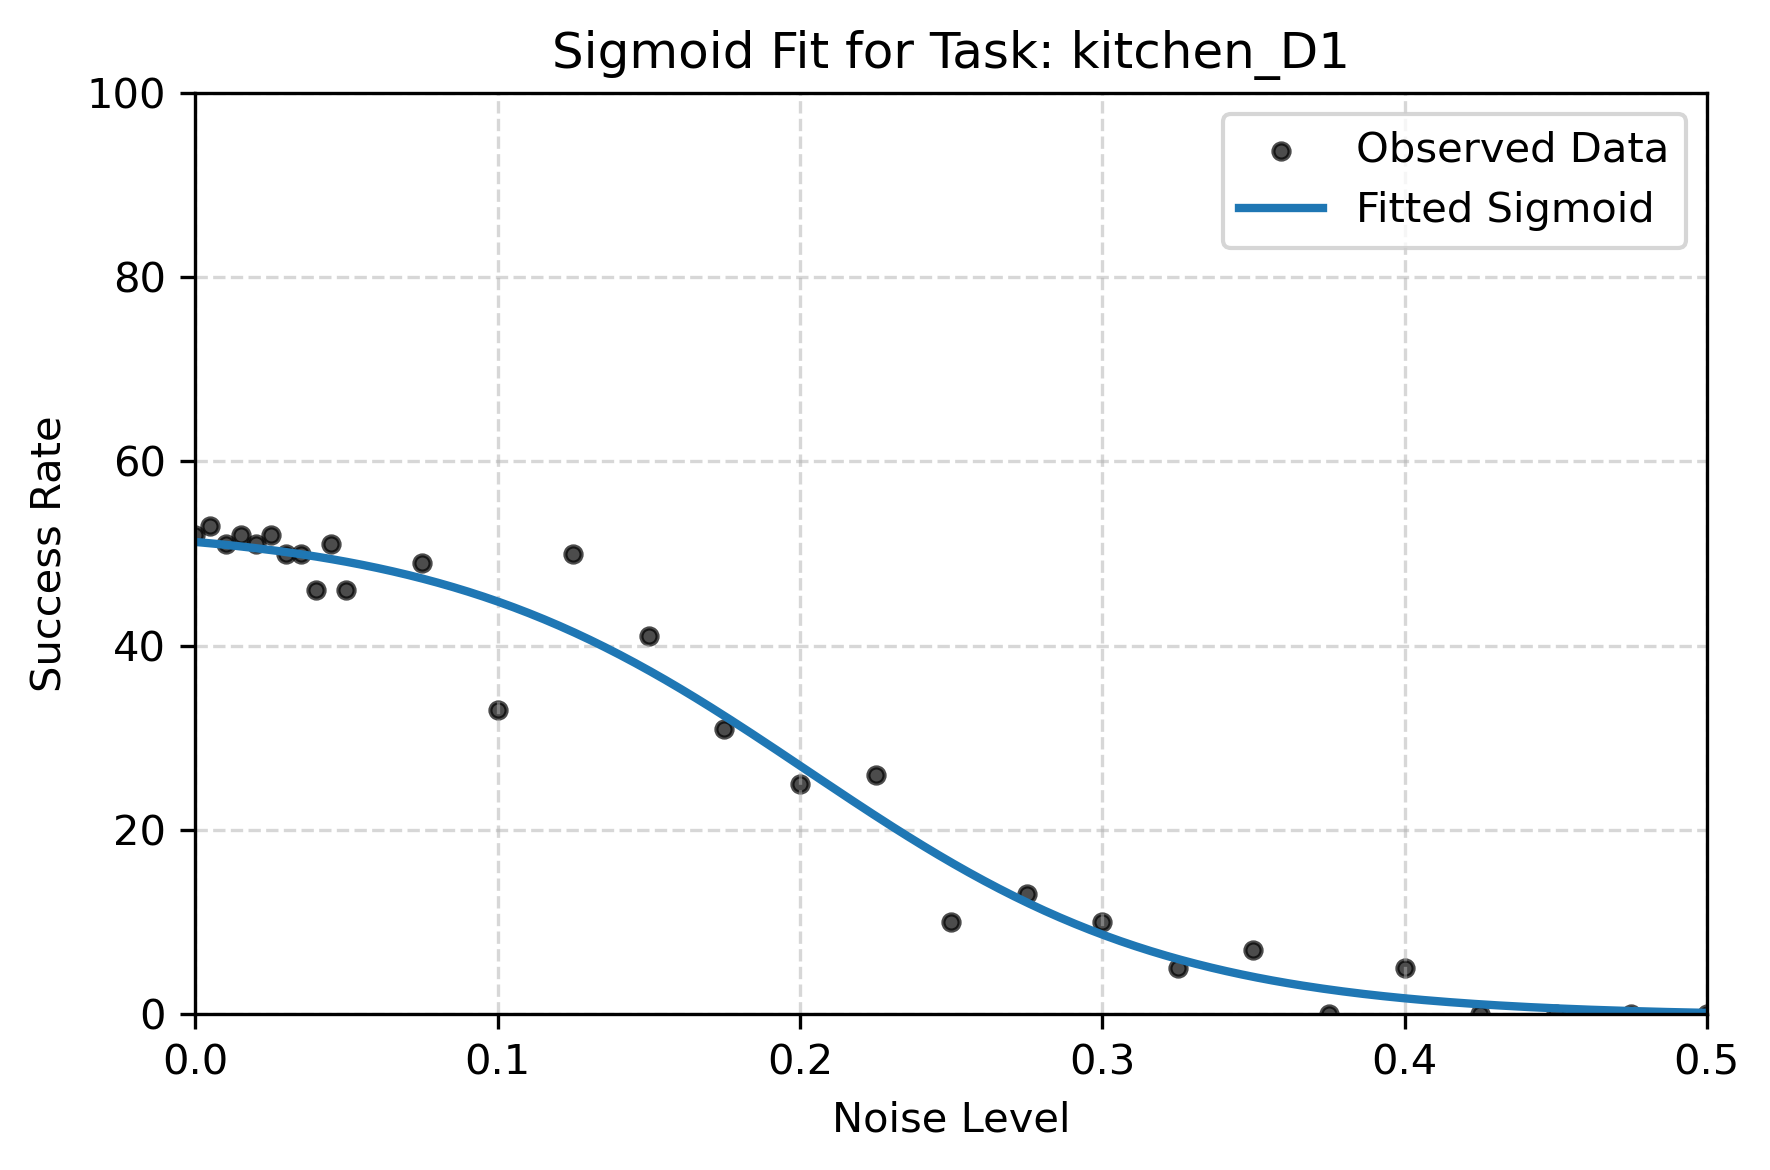

Parameters for task coffee_D1: [-67.15032877   0.99359083  20.02083817  -3.13311204]
Performance with 0 noise: 65
SSE: 354.3258083440832


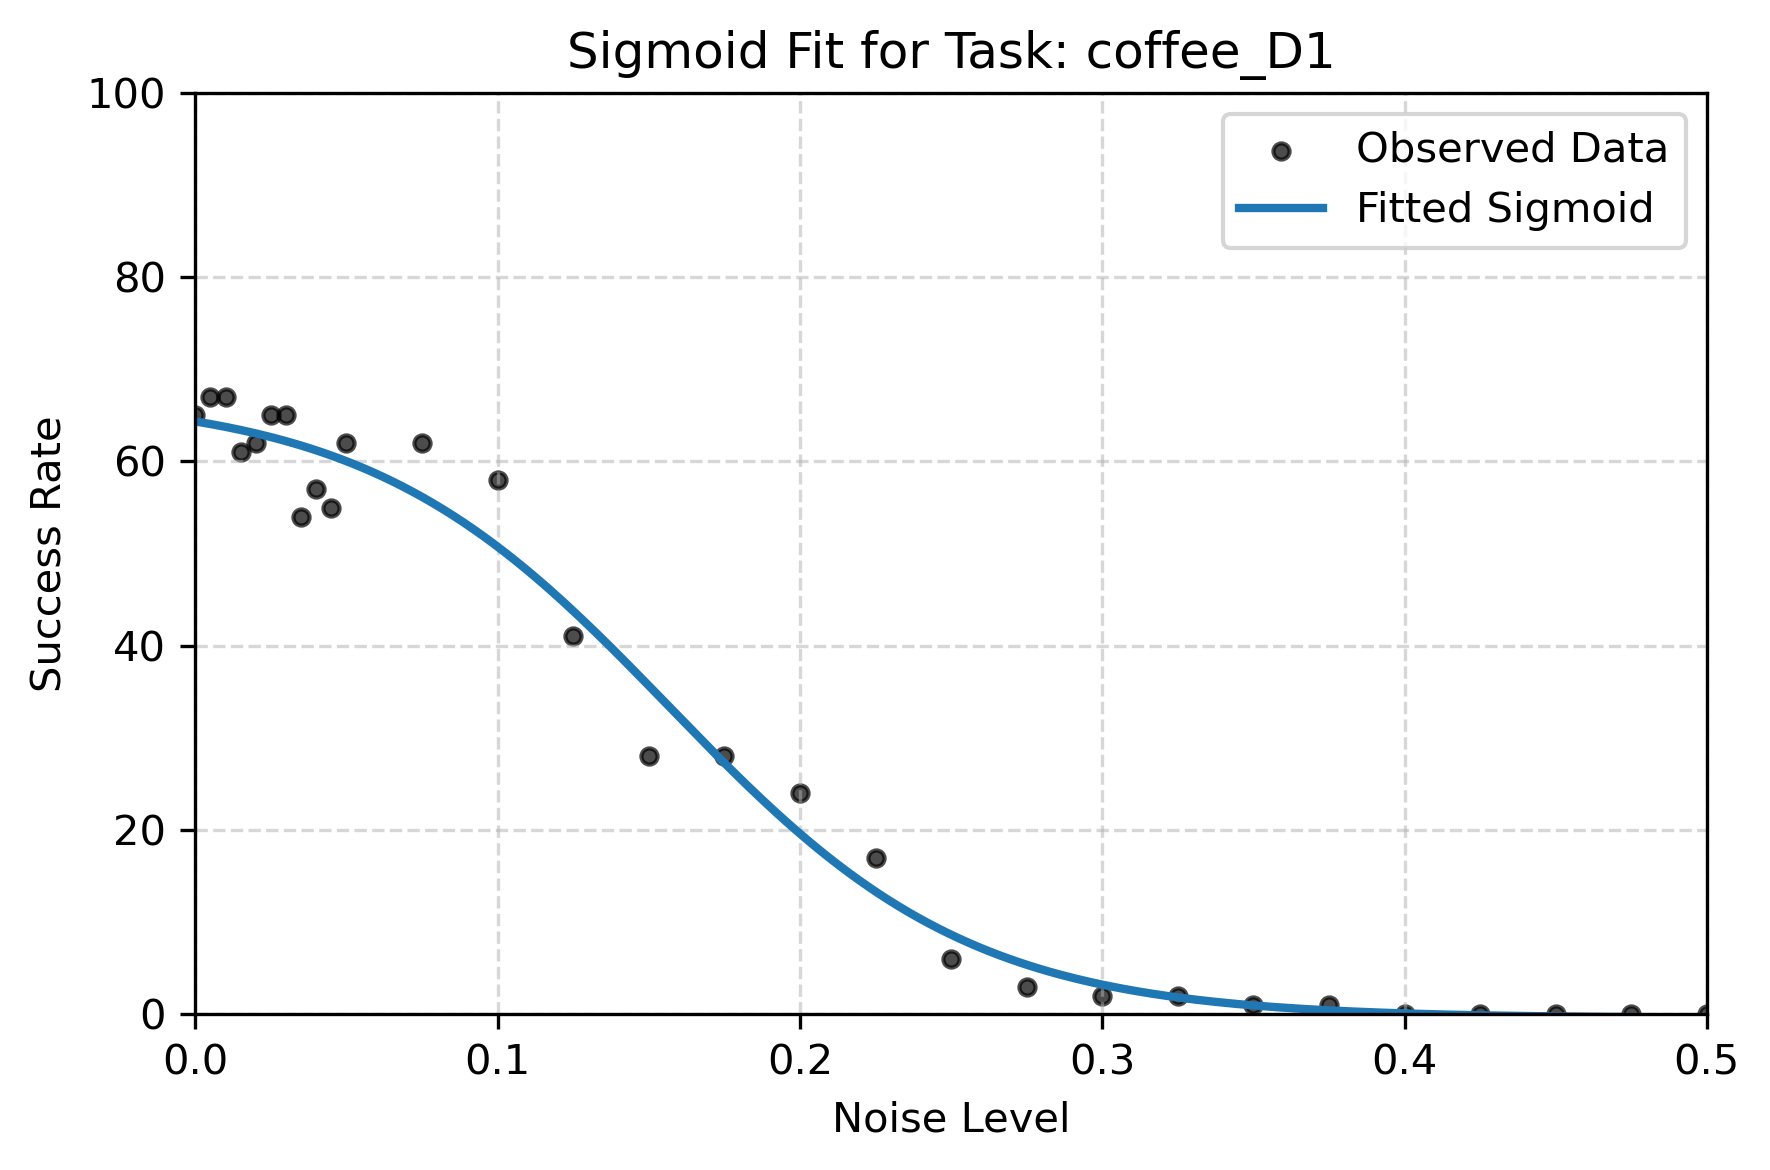

Parameters for task stack_three_D1: [-72.21069965   1.0401792   18.9806884   -3.57712528]
Performance with 0 noise: 68
SSE: 336.95791414158595


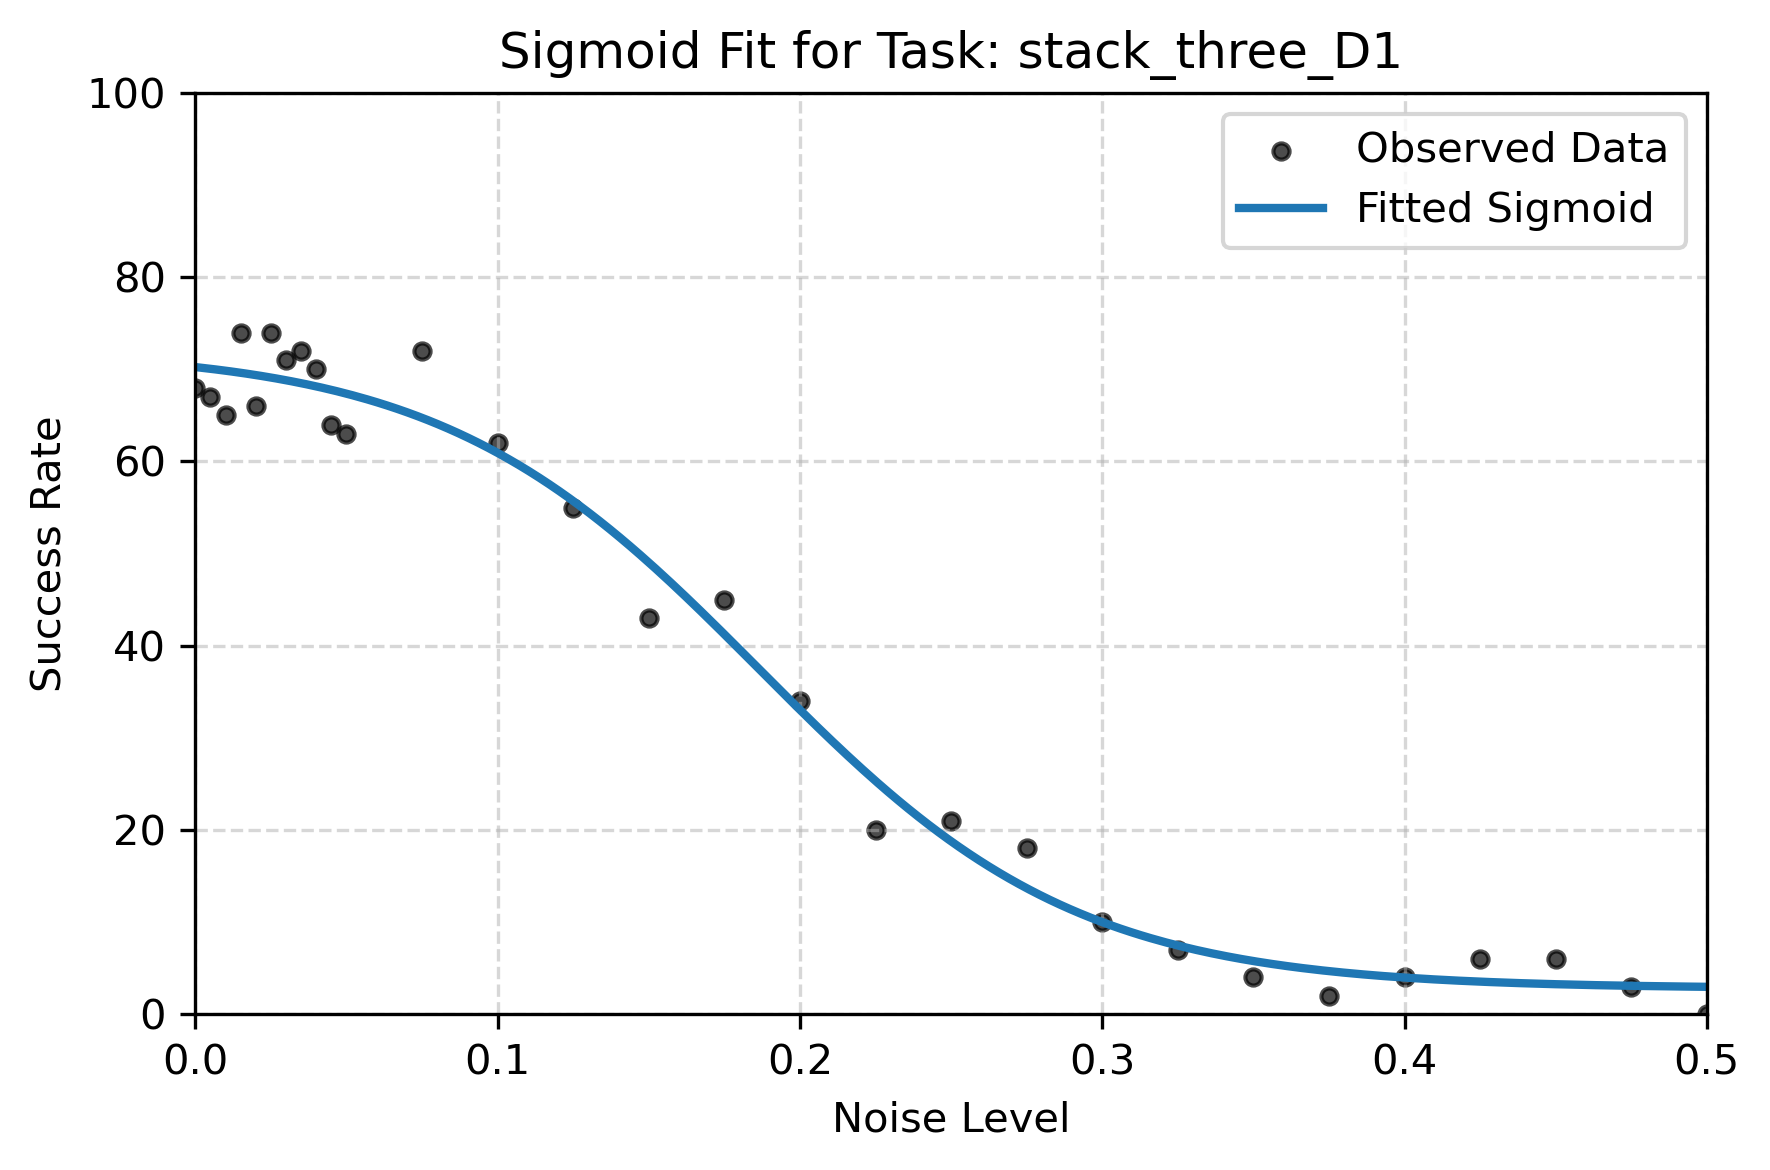

Parameters for task stack_D0: [-95.93540415   1.2372783   16.52325602  -5.77708881]
Performance with 0 noise: 93
SSE: 183.95122563748907


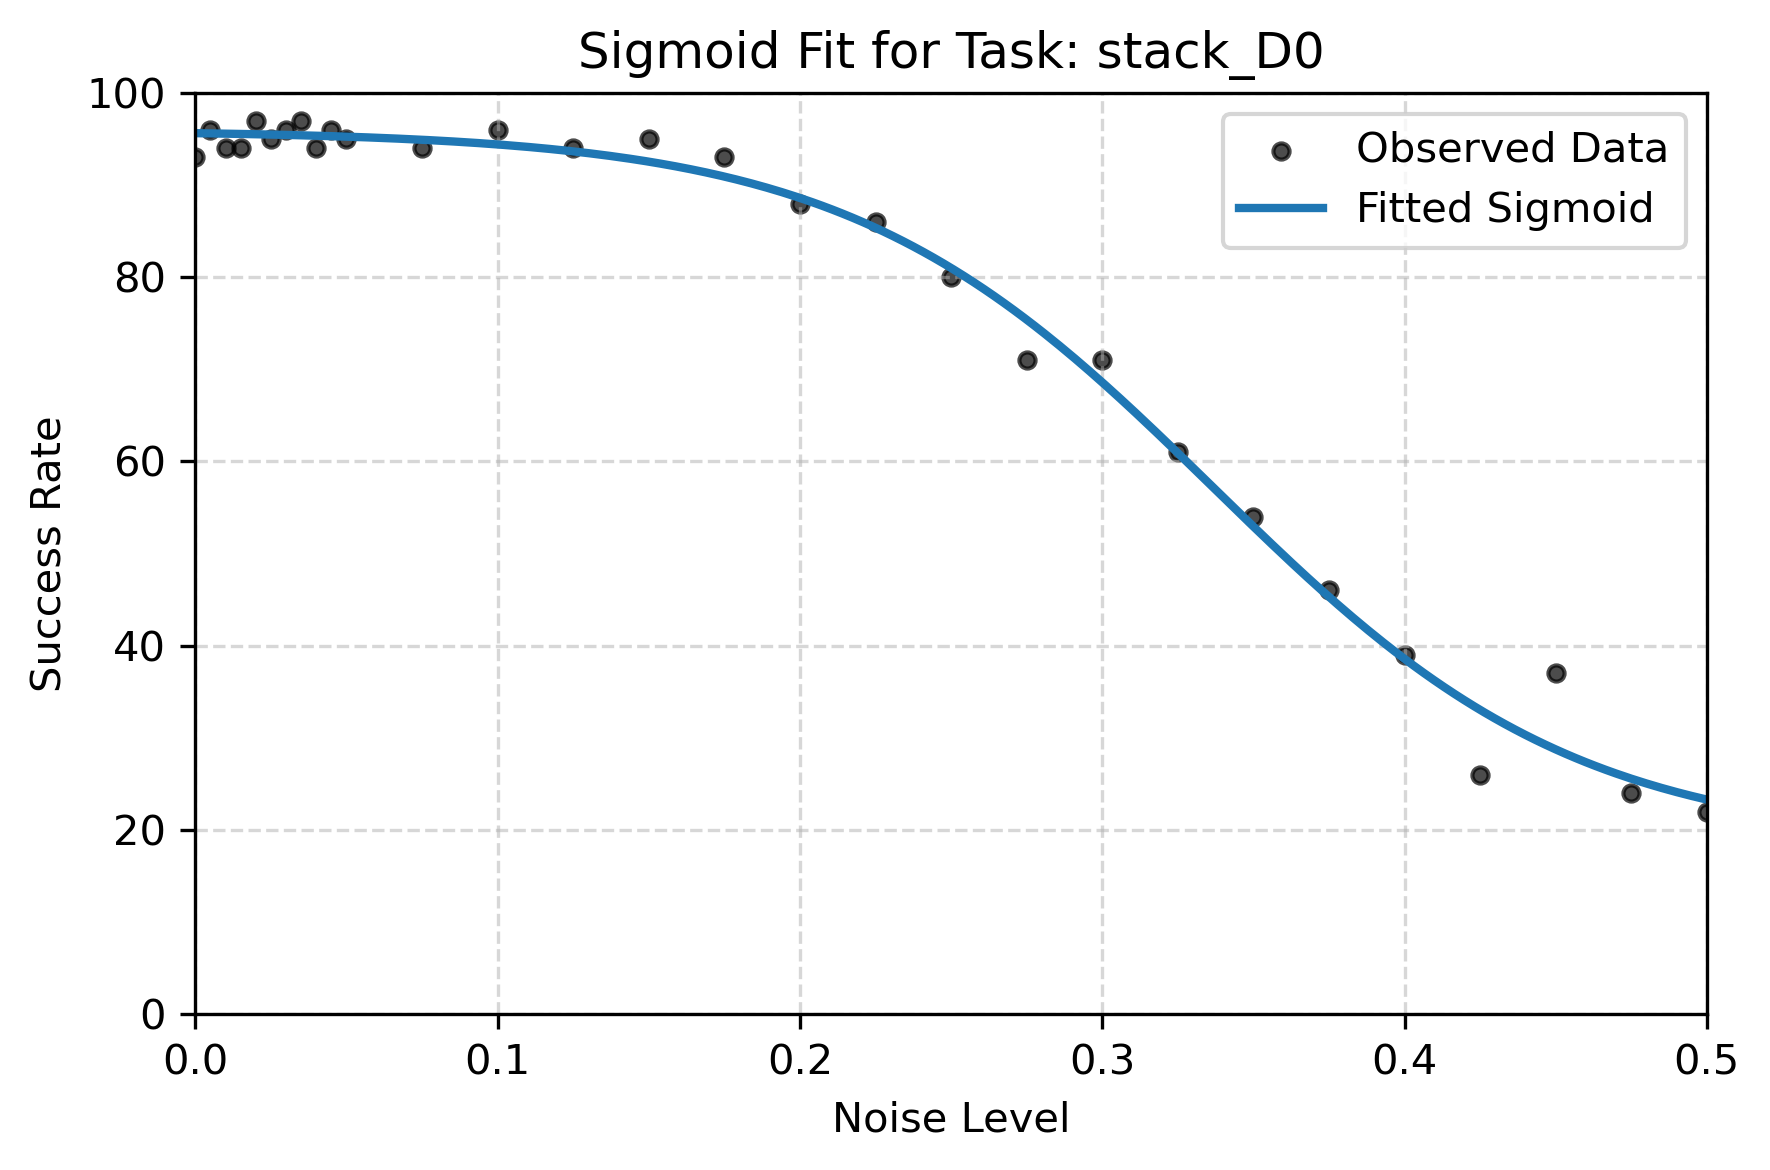

Parameters for task hammer_cleanup_D0: [-44.11827881   0.99237036  18.38165618  -4.4017922 ]
Performance with 0 noise: 43
SSE: 51.38491239307436


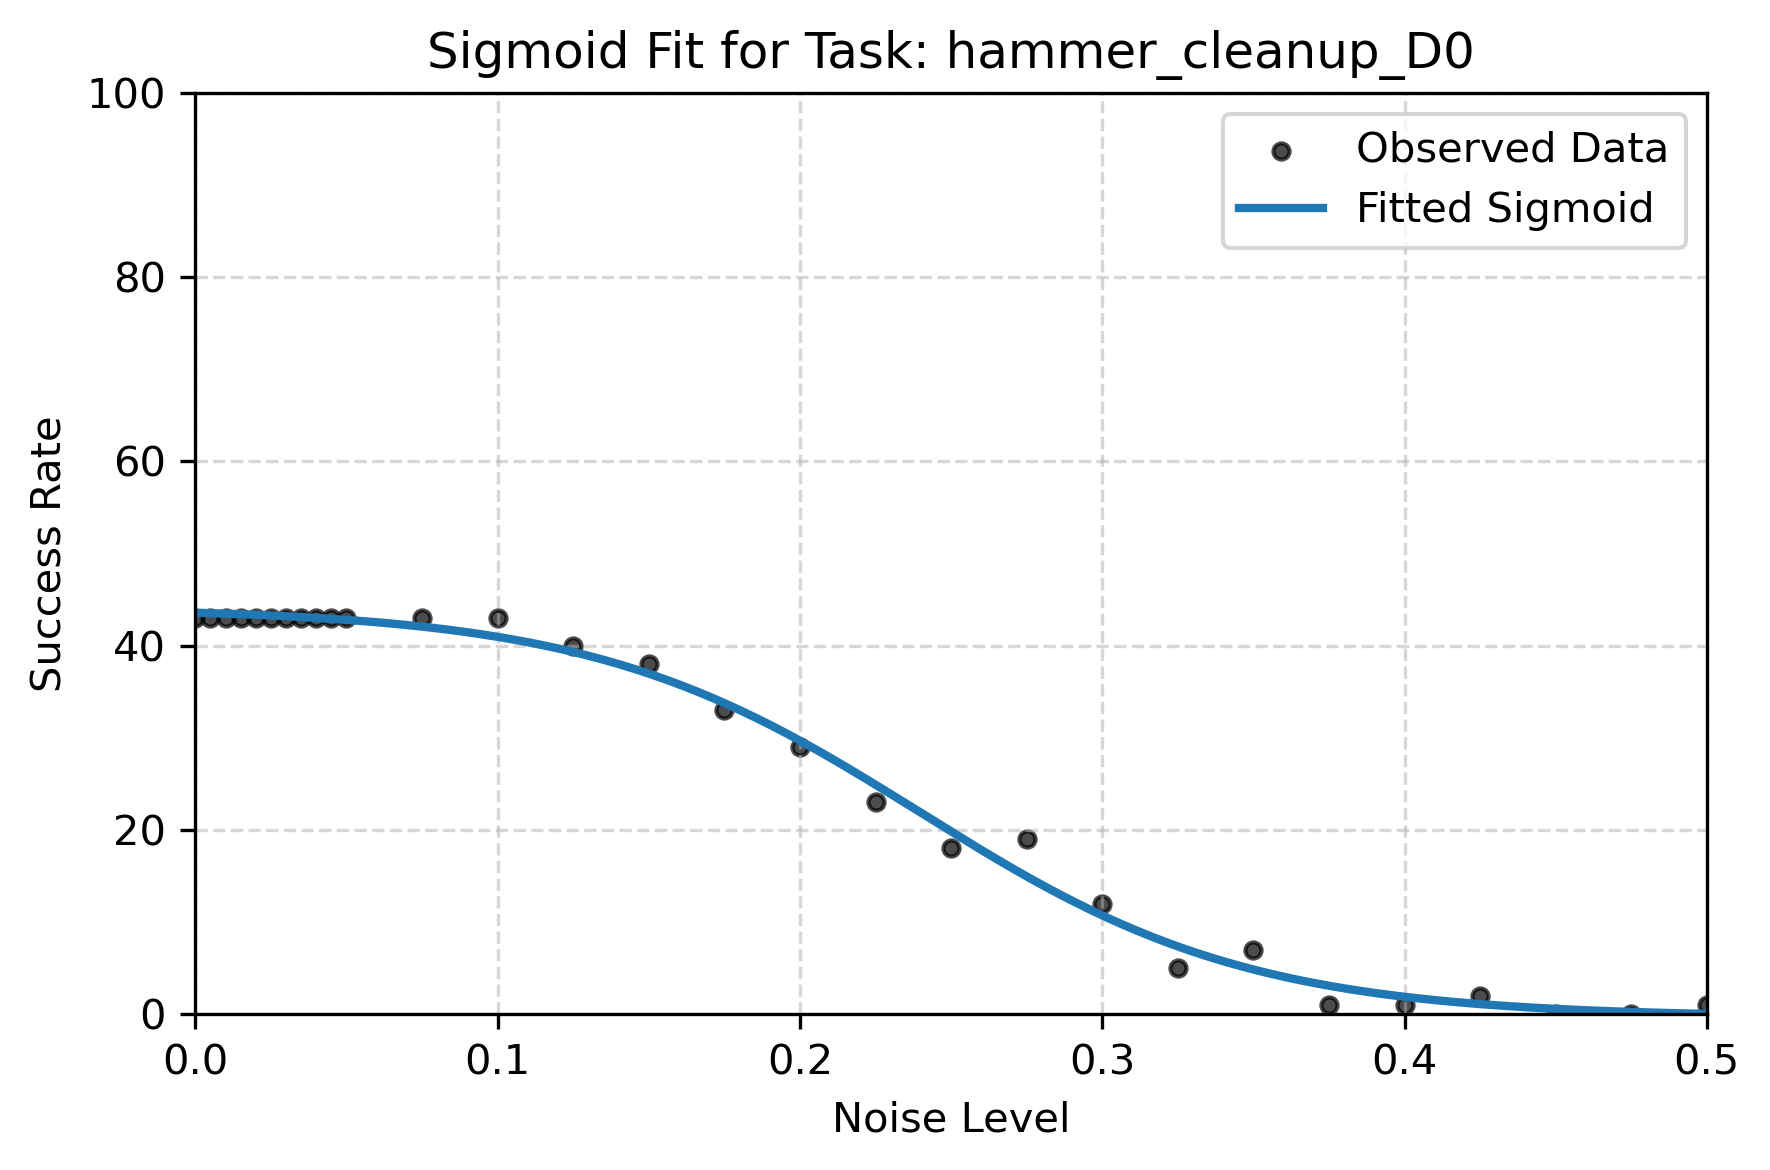

Parameters for task pick_place_D0: [-35.18967416   1.00734129  29.74014514  -3.97685795]
Performance with 0 noise: 39
SSE: 264.11606714681494


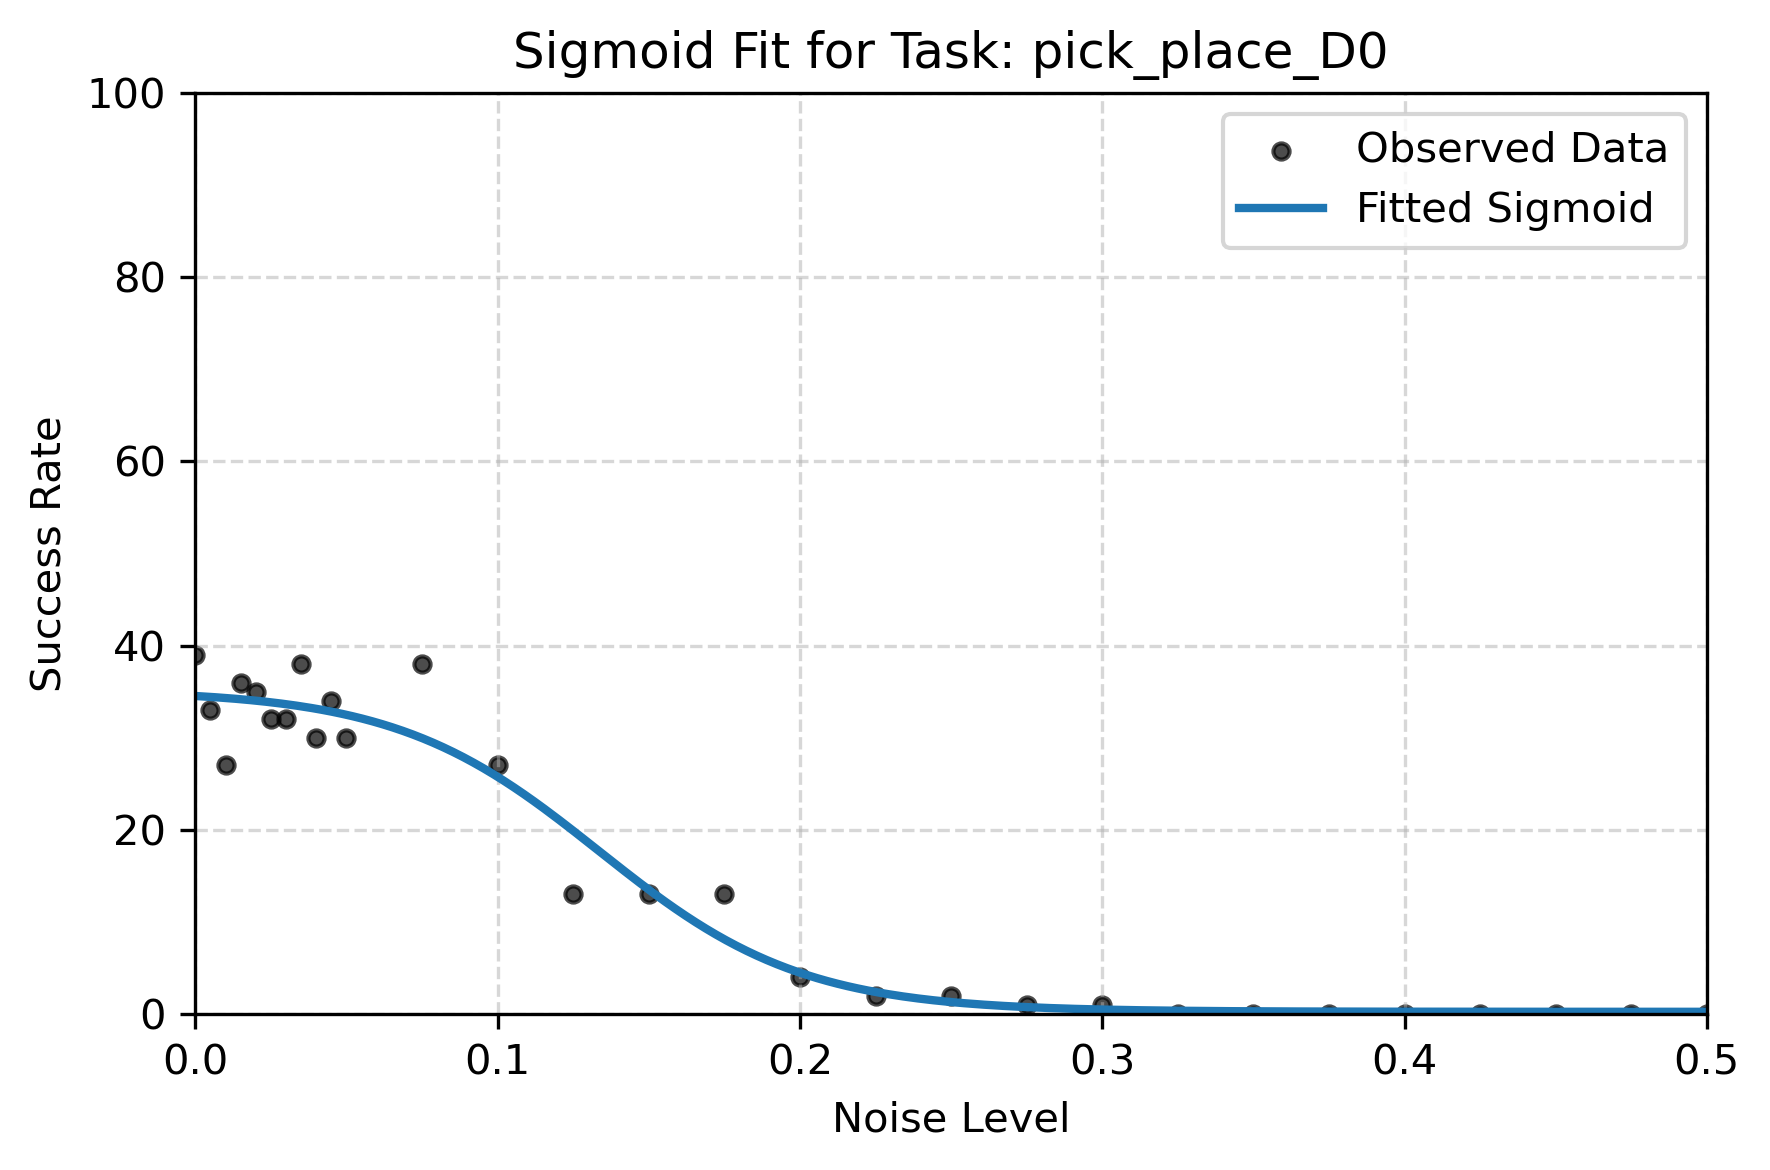

Parameters for task coffee_preparation_D1: [-40.29059807   0.99154813  25.03428828  -3.21550597]
Performance with 0 noise: 40
SSE: 113.67216580087997


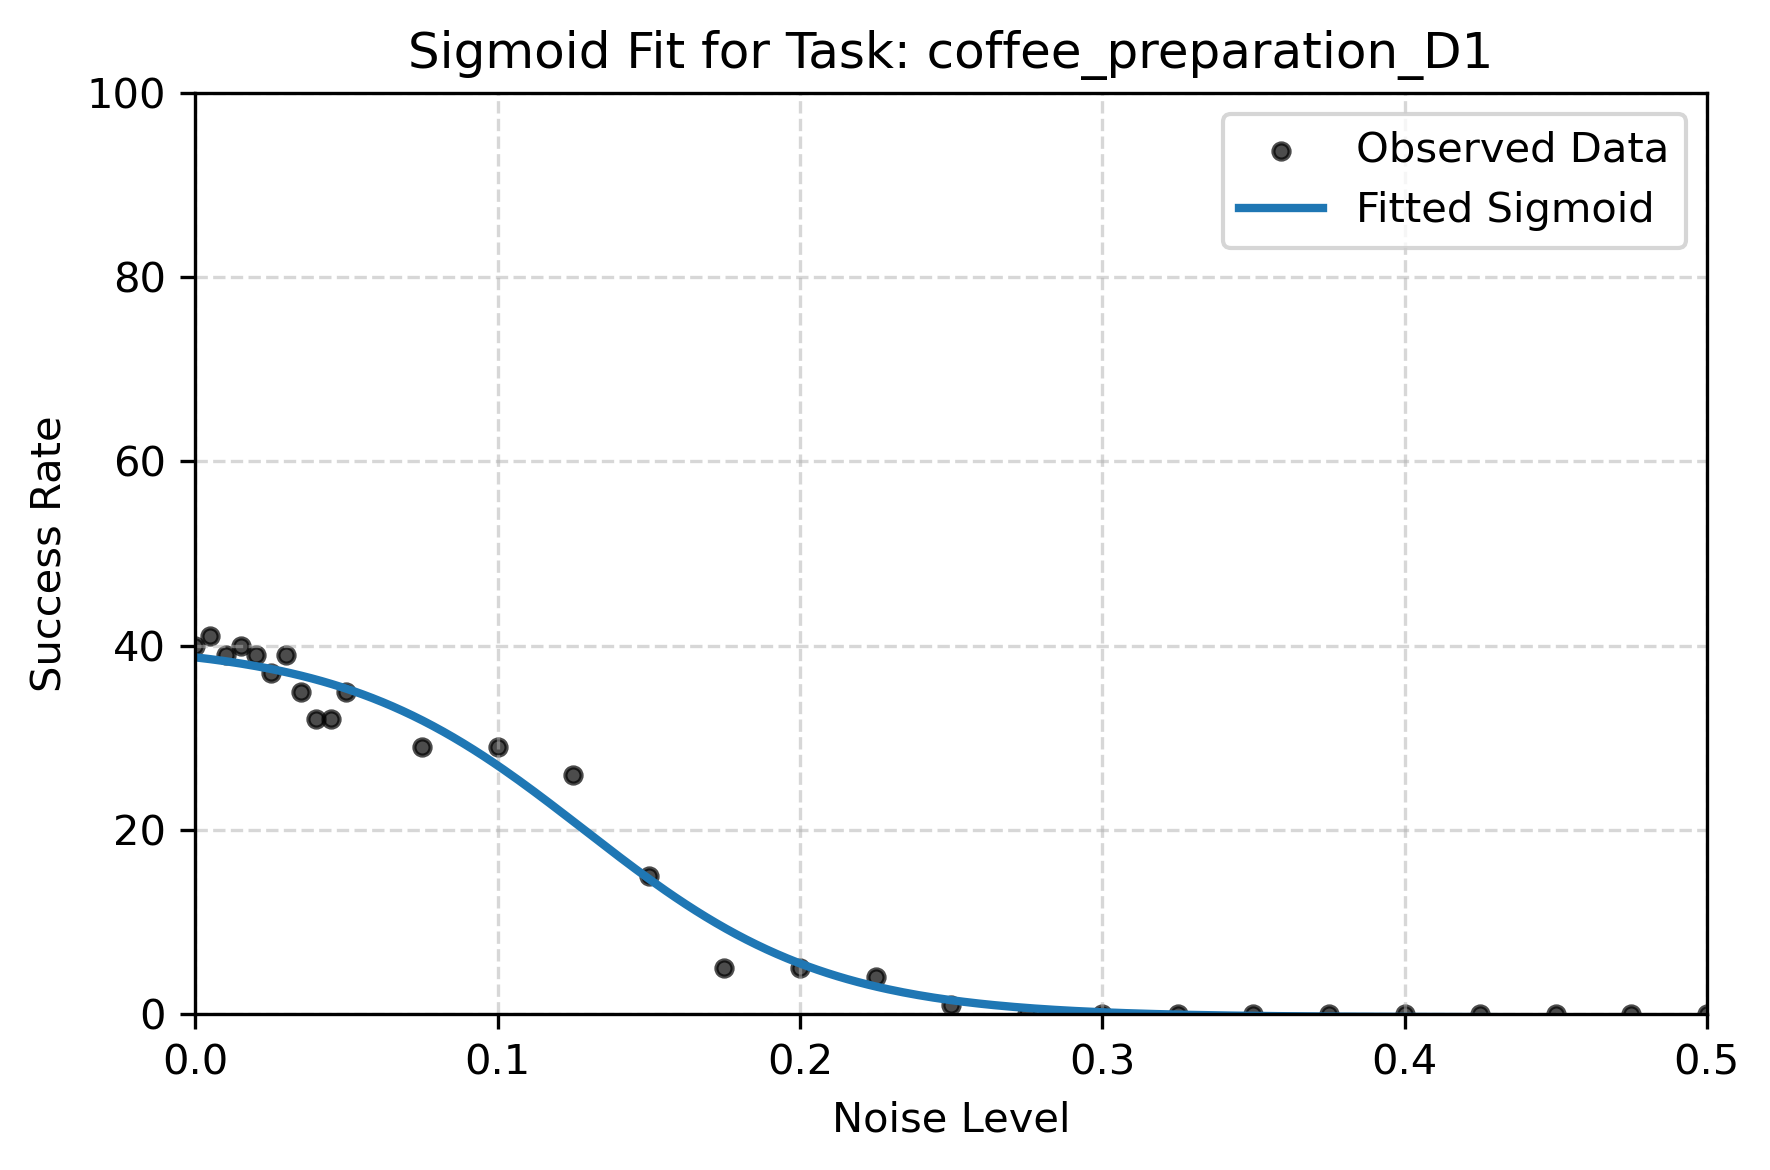

Parameters for task Cumulative_Data: [-54.06592499   1.0098287   16.35851451  -3.00944443]
Performance with 0 noise: 50.5
SSE: 48.07058531912567


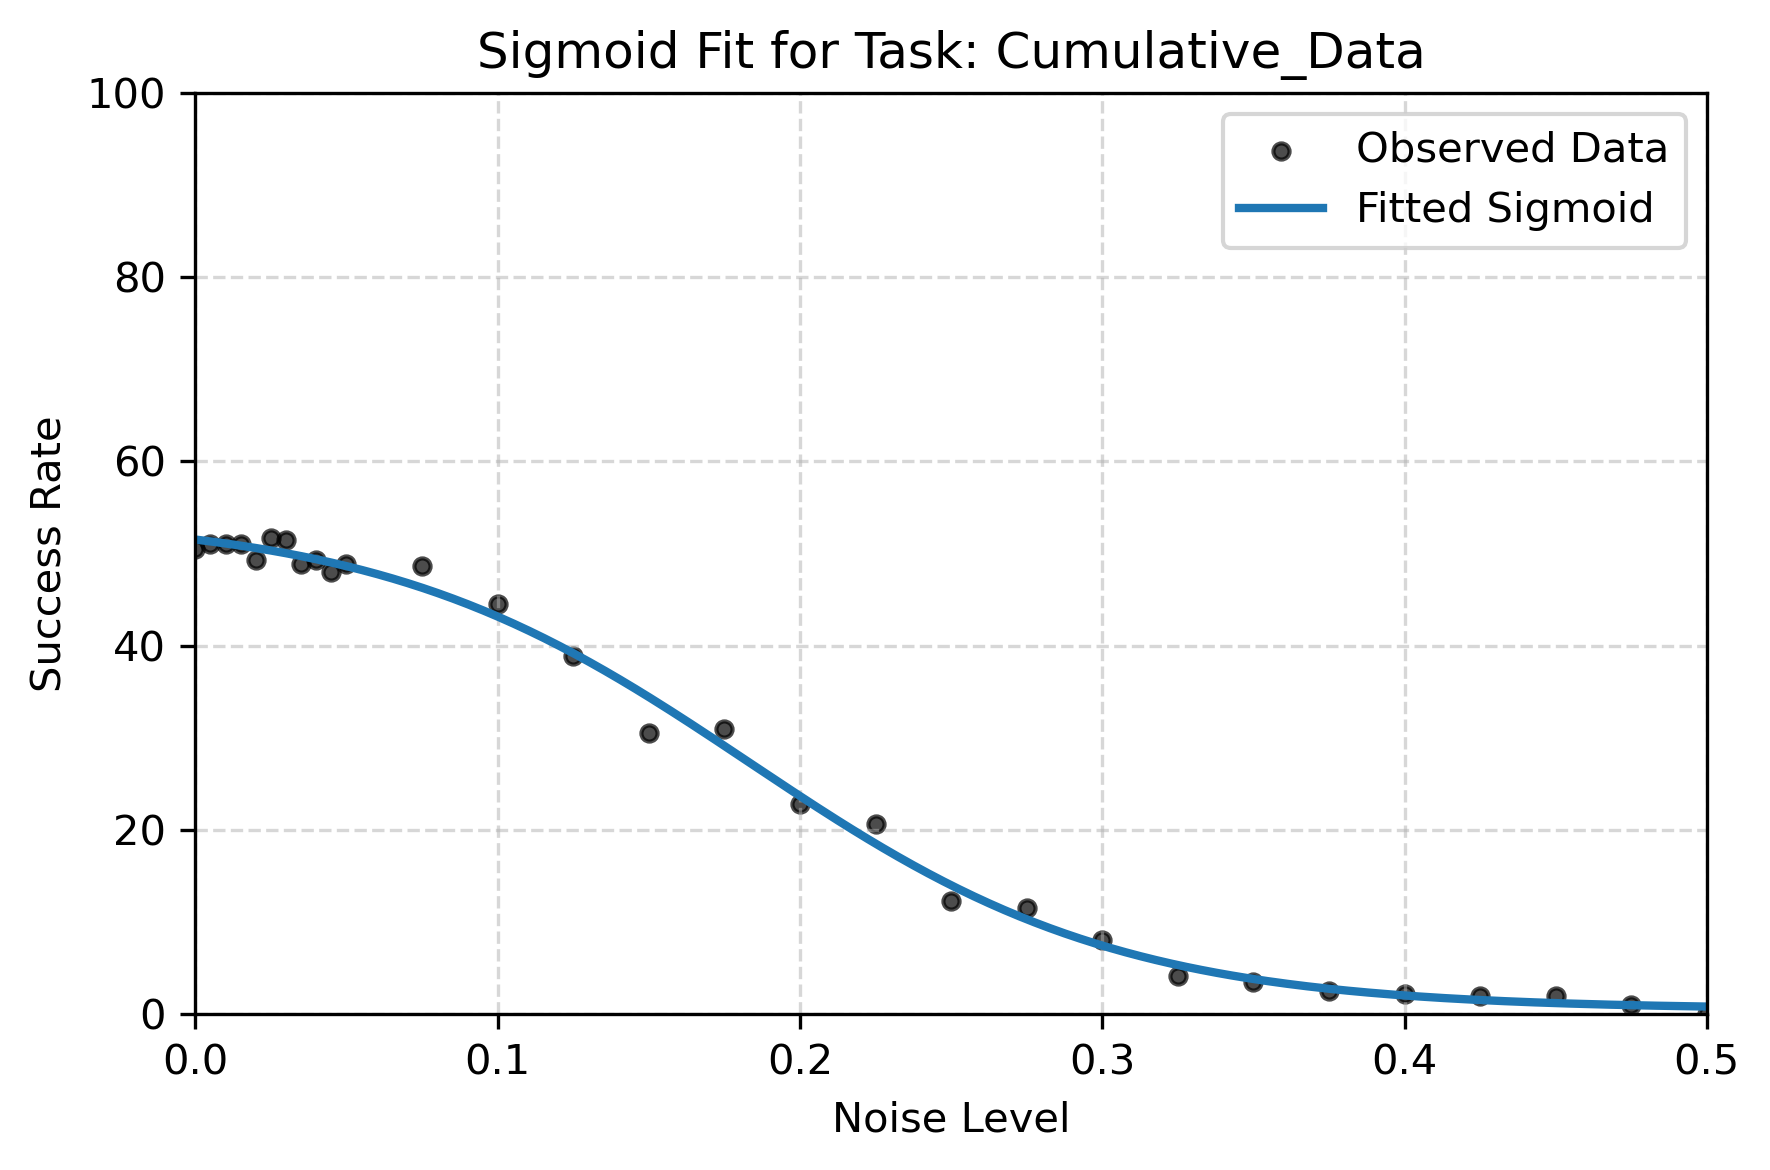

In [ ]:
learned_parameters = []

# Loop through each task

for task in tasks:
    data_dir = os.path.expanduser("~/MimicGenProject/MimicGenProject/data")
    output_csv = os.path.join(data_dir, f"{task}.csv")
    data = pd.read_csv(output_csv)
    data = data[data["noise"] < 1.0]

    # Your data
    x_data = data["noise"].to_numpy()
    y_data = data["success_rate"].to_numpy() if task != "Cumulative_Data" else data["avg accuracy"].to_numpy()

    # Your sigmoid function
    def custom_sigmoid(x, A, B, C, D):
        return A * (1/(B + np.exp(-C * x - D)) - 1)

    # Initial parameter guesses
    initial_guess = [-52.8, 1.0, 17.6, -3.32]

    param_bounds = (
    [-100, 0.01, 0.01, -10],   # Lower bounds: [A, B, C, D, E]
    [100, 10, 100, 10]          # Upper bounds
    )

    # Fit the model
    params_opt, params_cov = curve_fit(custom_sigmoid, x_data, y_data, p0=initial_guess, bounds=param_bounds)
    
    if task != "Cumulative_Data":
        # Add params_opt copy but with f(0) added to the list
        learned_parameters.append([y_data[0], params_opt[0], params_opt[1], params_opt[2], params_opt[3]])

    print(f"Parameters for task {task}: {str(params_opt)}")
    print(f"Performance with 0 noise: {y_data[0]}")
    SSE = np.sum((y_data - custom_sigmoid(x_data, *params_opt))**2)
    print(f"SSE: {SSE}")
    # Put the SSE in the summary_statistics DataFrame
    summary_statistics.loc[task, 'SSE1'] = SSE
    # Add RMSE and MAE to summary_statistics
    RMSE = np.sqrt(SSE / len(x_data))
    MAE = np.mean(np.abs(y_data - custom_sigmoid(x_data, *params_opt)))
    summary_statistics.loc[task, 'RMSE1'] = RMSE
    summary_statistics.loc[task, 'MAE1'] = MAE
    # Add R^2 to summary_statistics
    y_mean = np.mean(y_data)
    SS_total = np.sum((y_data - y_mean)**2)
    SS_residual = np.sum((y_data - custom_sigmoid(x_data, *params_opt))**2)
    R_squared = 1 - (SS_residual / SS_total)
    summary_statistics.loc[task, 'R_squared1'] = R_squared
    
    # Plot
    plt.figure(figsize=(6, 4), dpi=300)
    plt.scatter(x_data, y_data, label='Observed Data', color='black', s=15, alpha=0.7)

    x_fit = np.linspace(min(x_data), max(x_data), 300)
    y_fit = custom_sigmoid(x_fit, *params_opt)
    plt.plot(x_fit, y_fit, label='Fitted Sigmoid', linewidth=2)

    # Labels and styling
    plt.title(f"Sigmoid Fit for Task: {task}", fontsize=12)
    plt.xlabel("Noise Level", fontsize=10)
    plt.ylabel("Success Rate", fontsize=10)
    plt.ylim(0,100)
    plt.xlim(0,.5)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()

    # Optional: save figure
    # fig_path = os.path.join(data_dir, f"{task}_fit.png")
    # plt.savefig(fig_path, dpi=300)
    if SAVE_FILE:
        plt.savefig(os.path.join(data_dir, f"charts/full_sigmoid/{task}_fit.png"), dpi=300)
    plt.show()

In [32]:
def fit_parameter_models(task_params):
    data = np.array(task_params)
    P_vals = data[:, 0]  # Assumed equal to A and D
    B_vals = data[:, 2]
    C_vals = data[:, 3]
    E_vals = data[:, 4]

    # Fit linear regressions: param = a*P + b
    def fit_linear(y):
        model = LinearRegression()
        model.fit(P_vals.reshape(-1, 1), y)
        return model.coef_[0], model.intercept_

    b1, b0 = fit_linear(B_vals)
    c1, c0 = fit_linear(C_vals)
    e1, e0 = fit_linear(E_vals)

    print(f"Fitted parameter models:")
    print(f"B(P) = {b0:.4f} + {b1:.4f} * P")
    print(f"C(P) = {c0:.4f} + {c1:.4f} * P")
    print(f"E(P) = {e0:.4f} + {e1:.4f} * P")

    # Return a predictive sigmoid function
    def predicted_sigmoid(x, P):
        A = -P
        B = b0 + b1 * P
        C = c0 + c1 * P
        E = e0 + e1 * P
        return A / (B + np.exp(-C * x - E)) + A + 2*P

    return predicted_sigmoid

In [33]:
print(learned_parameters)

[[42, -45.83135872965051, 0.9742106754562609, 11.322164087488755, -2.710648769408732], [53, -54.757044509427814, 1.0033282369944372, 20.305021942473623, -3.629921834122213], [23, -26.30720954430043, 1.0255699849642825, 19.295835900861253, -3.436615906499969], [52, -53.084344609565804, 0.9953389729634623, 16.509247912282977, -3.339166152996724], [65, -67.15032877131353, 0.9935908330576871, 20.02083816642047, -3.133112044913083], [68, -72.21069965369502, 1.0401791966472451, 18.98068839758799, -3.5771252817783274], [93, -95.93540414541364, 1.2372782955391972, 16.52325601925555, -5.777088811671111], [43, -44.11827881379115, 0.9923703553267238, 18.38165618153863, -4.401792198685566], [39, -35.18967415744847, 1.007341291479437, 29.74014514172704, -3.976857951913116], [40, -40.29059807171648, 0.9915481274954793, 25.034288283866204, -3.215505969530374]]


Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P


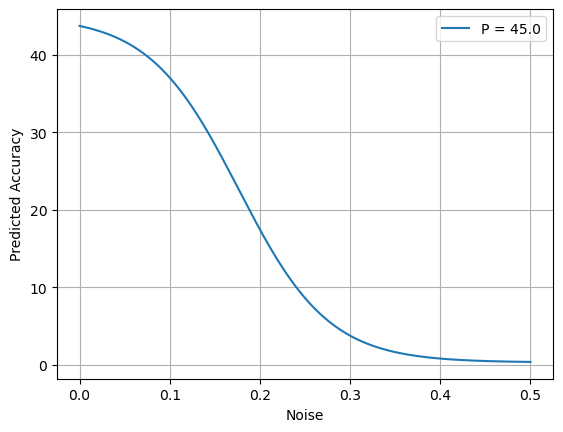

In [ ]:
sigmoid_fn = fit_parameter_models(learned_parameters)

# Plot for a given P
x = np.linspace(0, 0.5, 200)
P = 45.0
y = sigmoid_fn(x, P)

# plt.plot(x, y, label=f"P = {P}")
# plt.xlabel("Noise")
# plt.ylabel("Predicted Accuracy")
# plt.legend()
# plt.grid(True)
# plt.show()

Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P
SSE: 1778.0751382245783


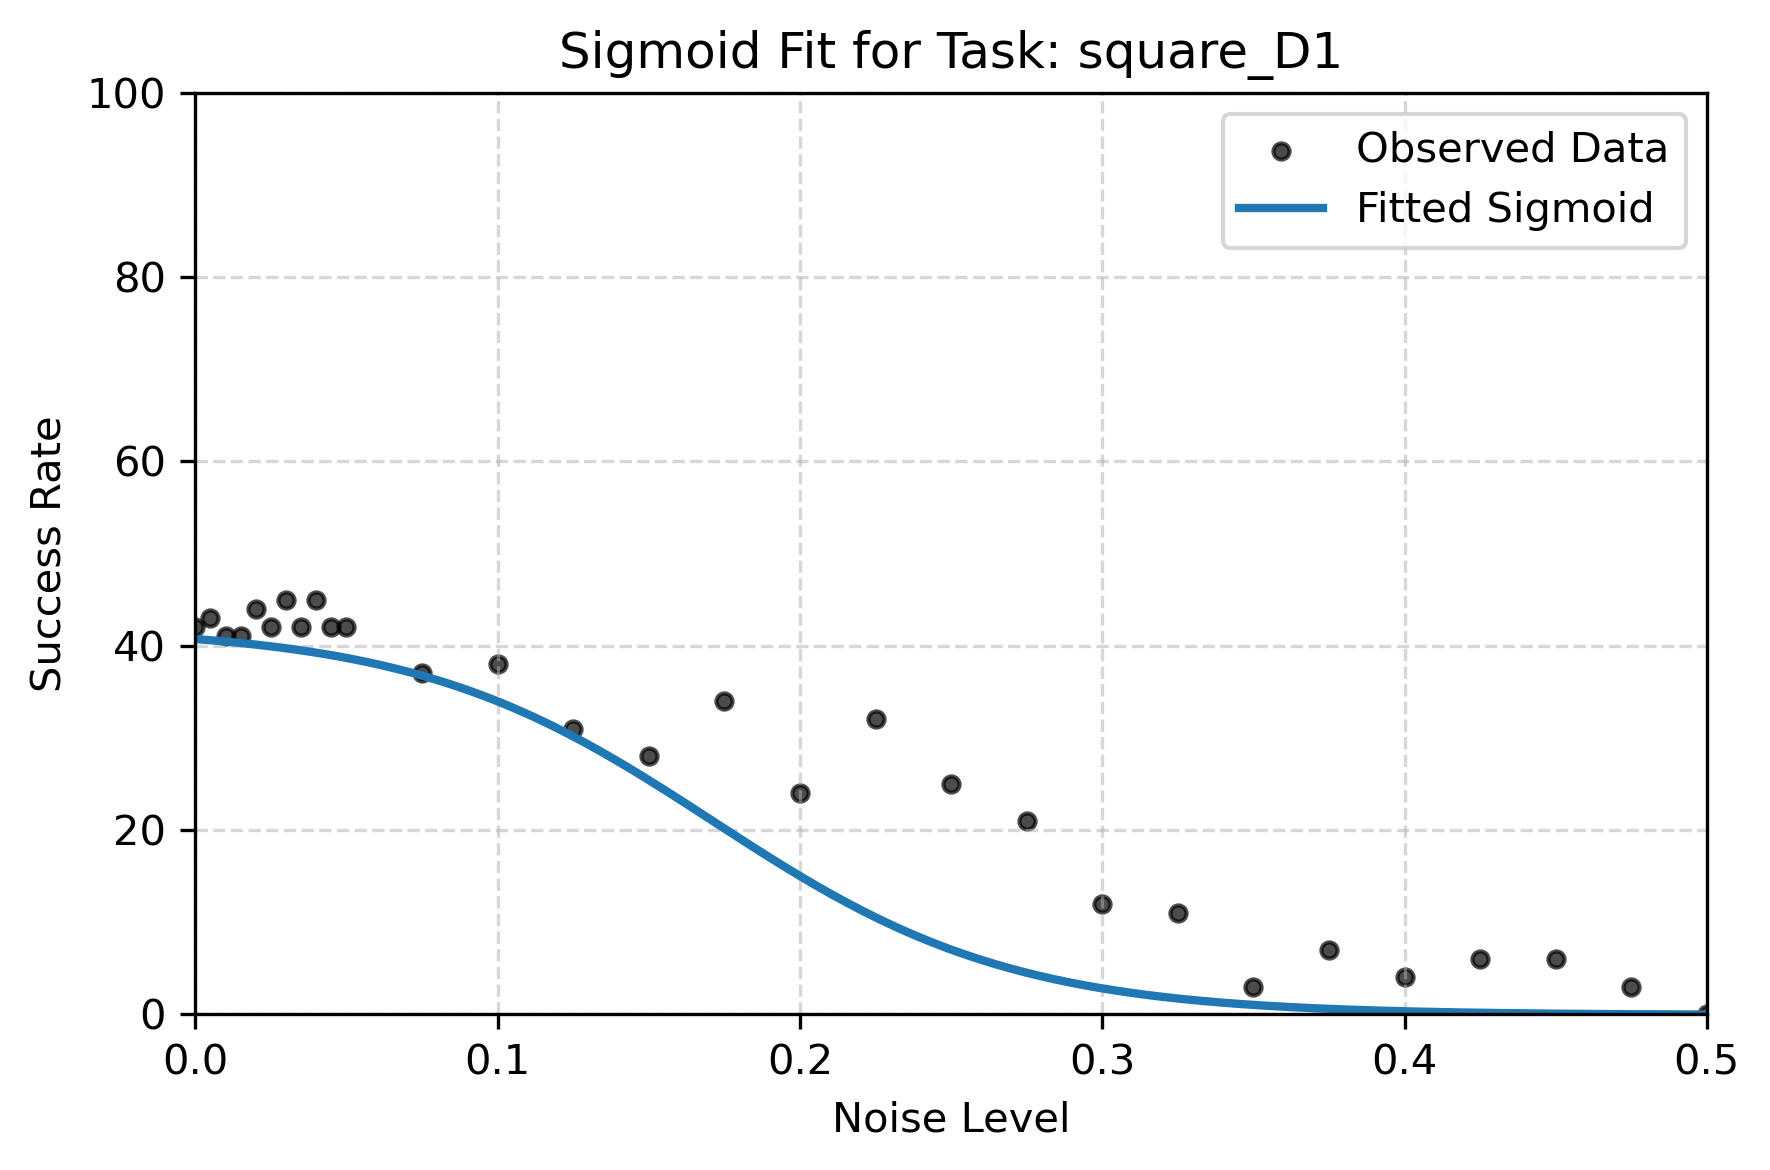

Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P
SSE: 380.5101819047033


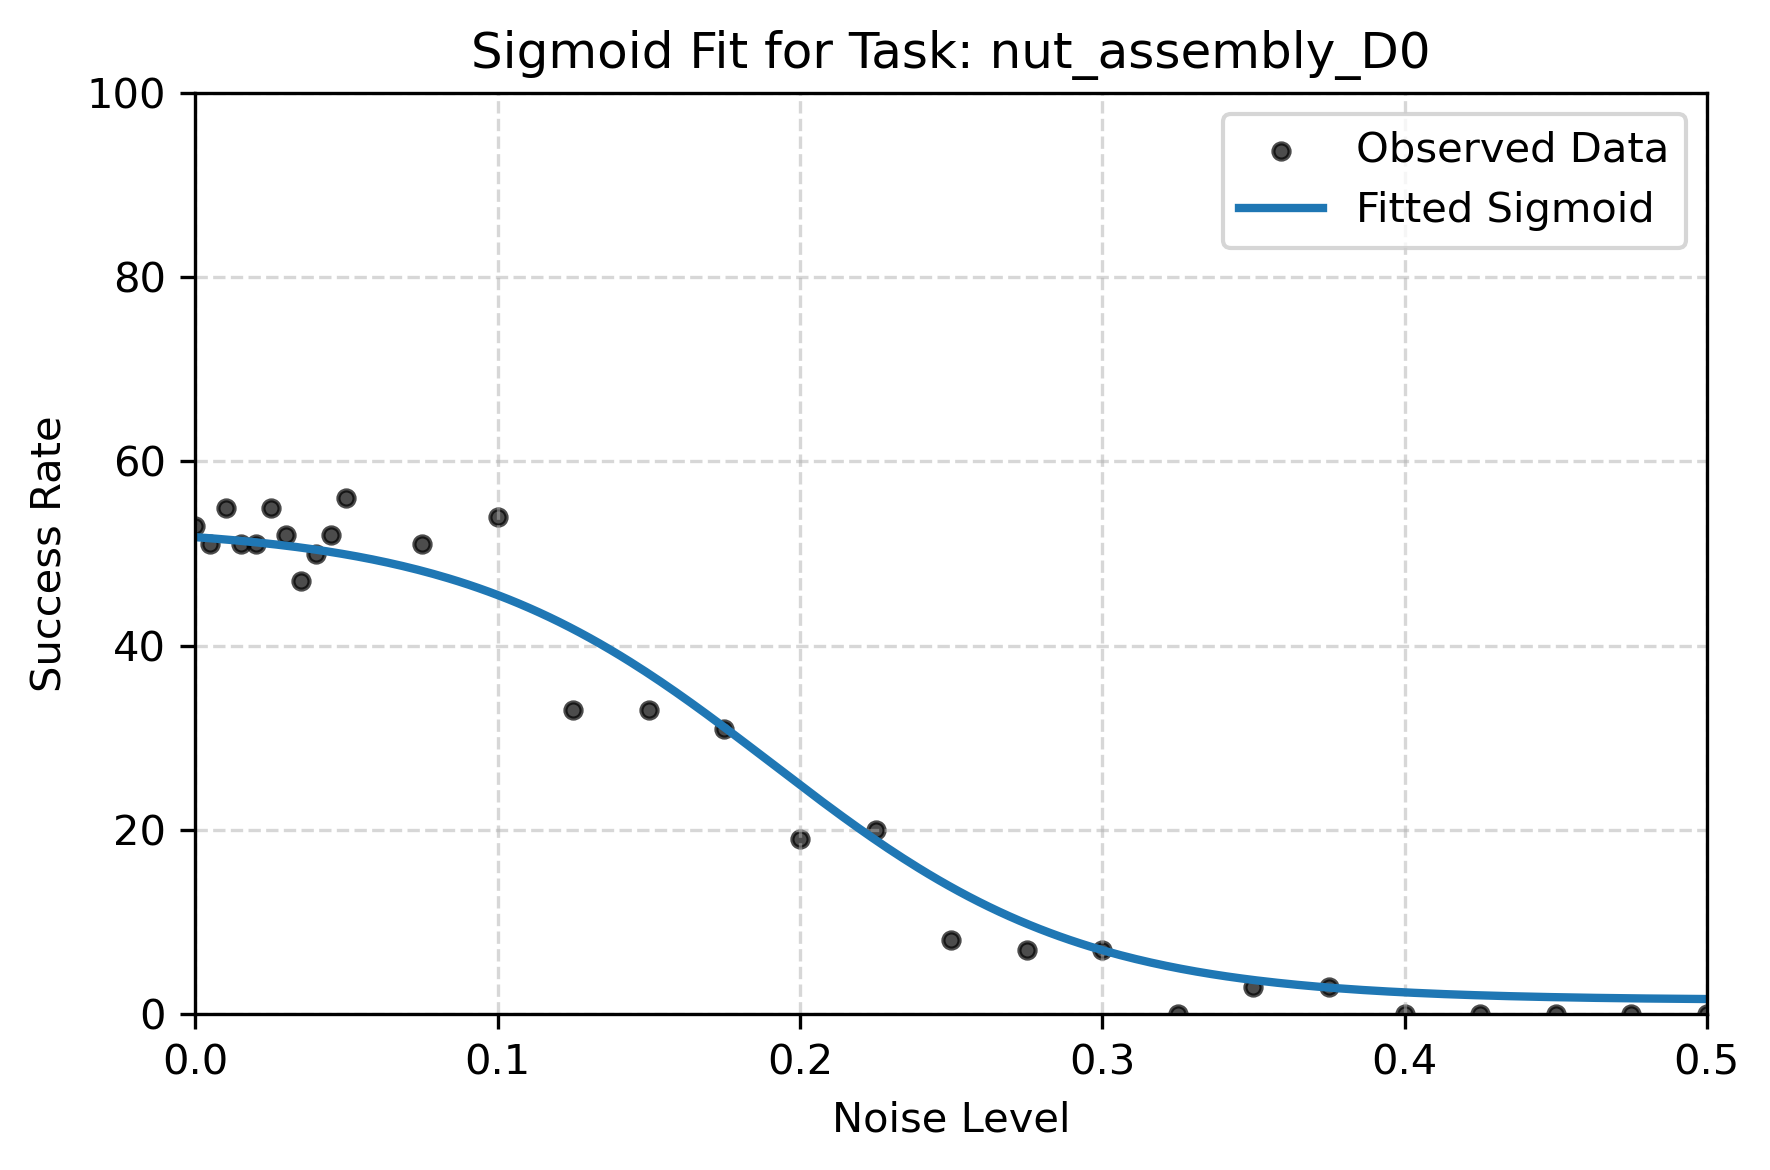

Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P
SSE: 689.5421696563402


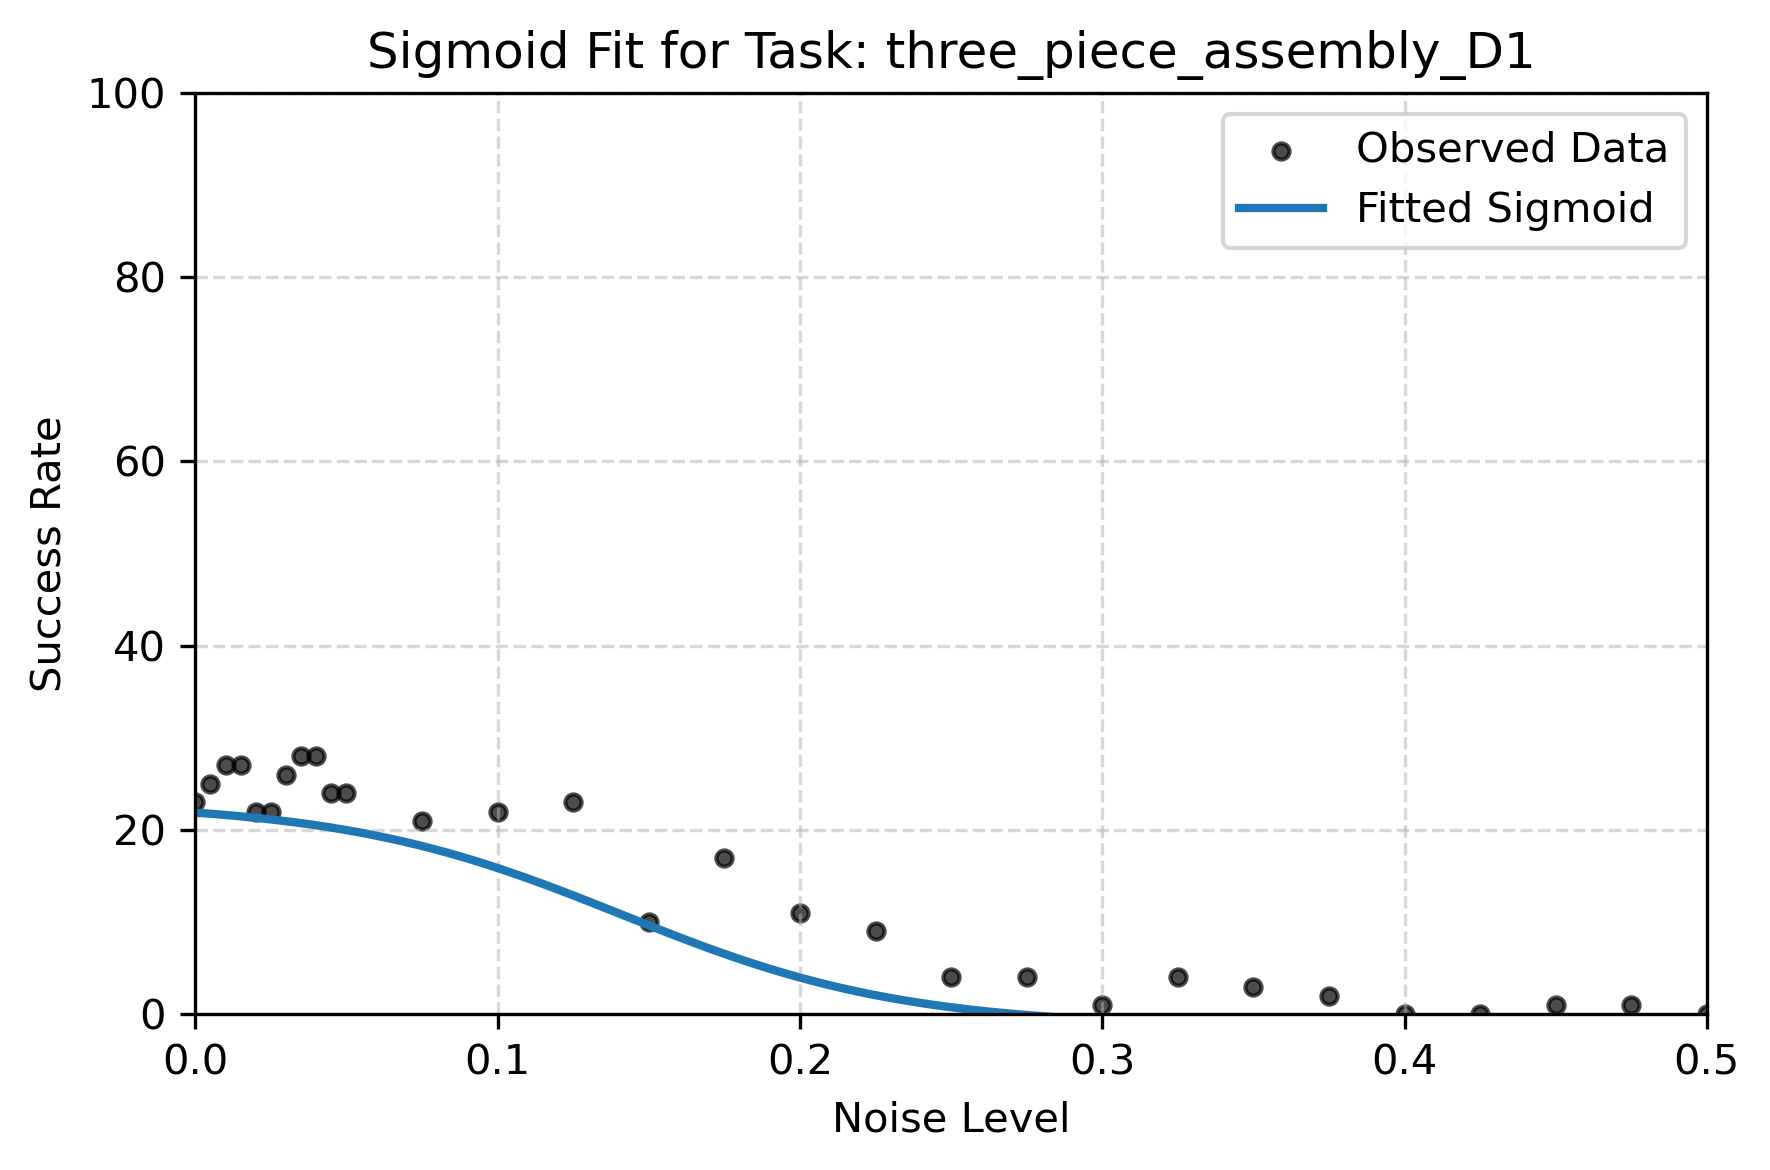

Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P
SSE: 425.10933366930396


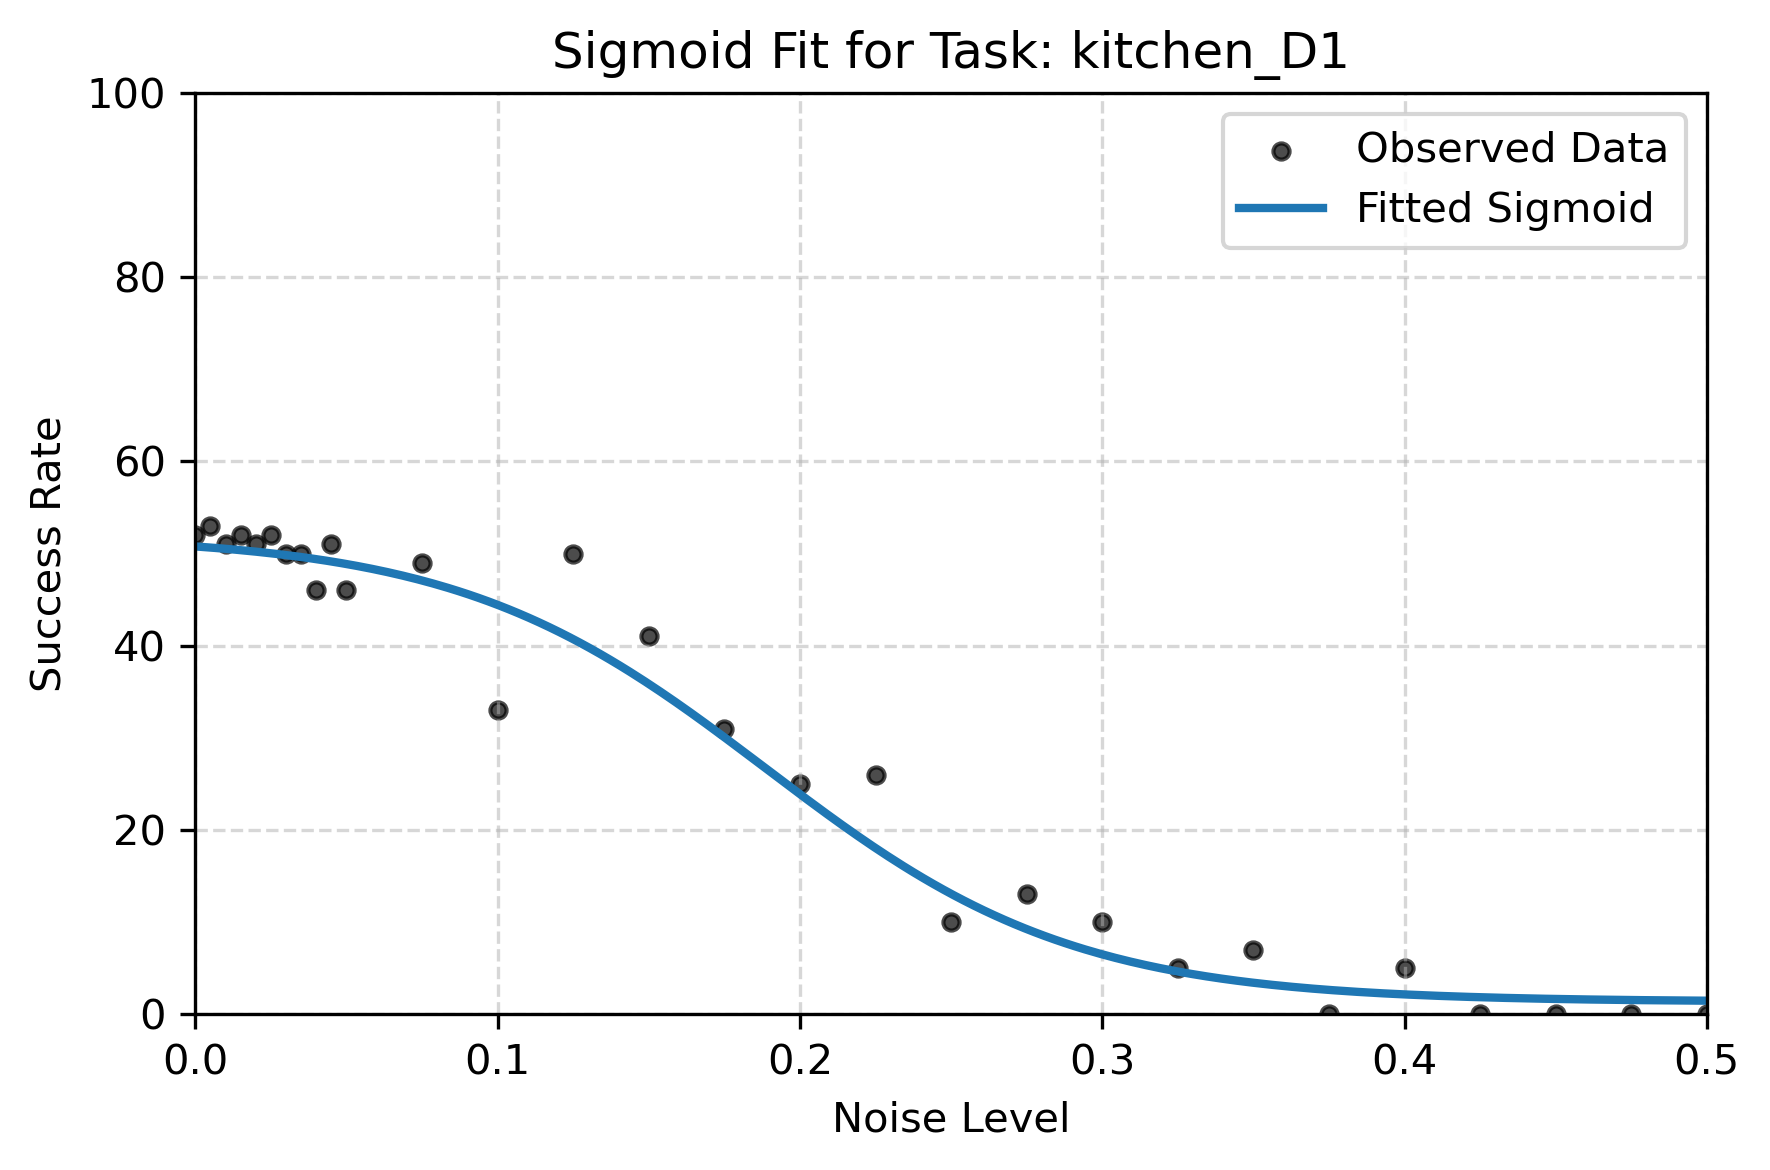

Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P
SSE: 2615.043126799082


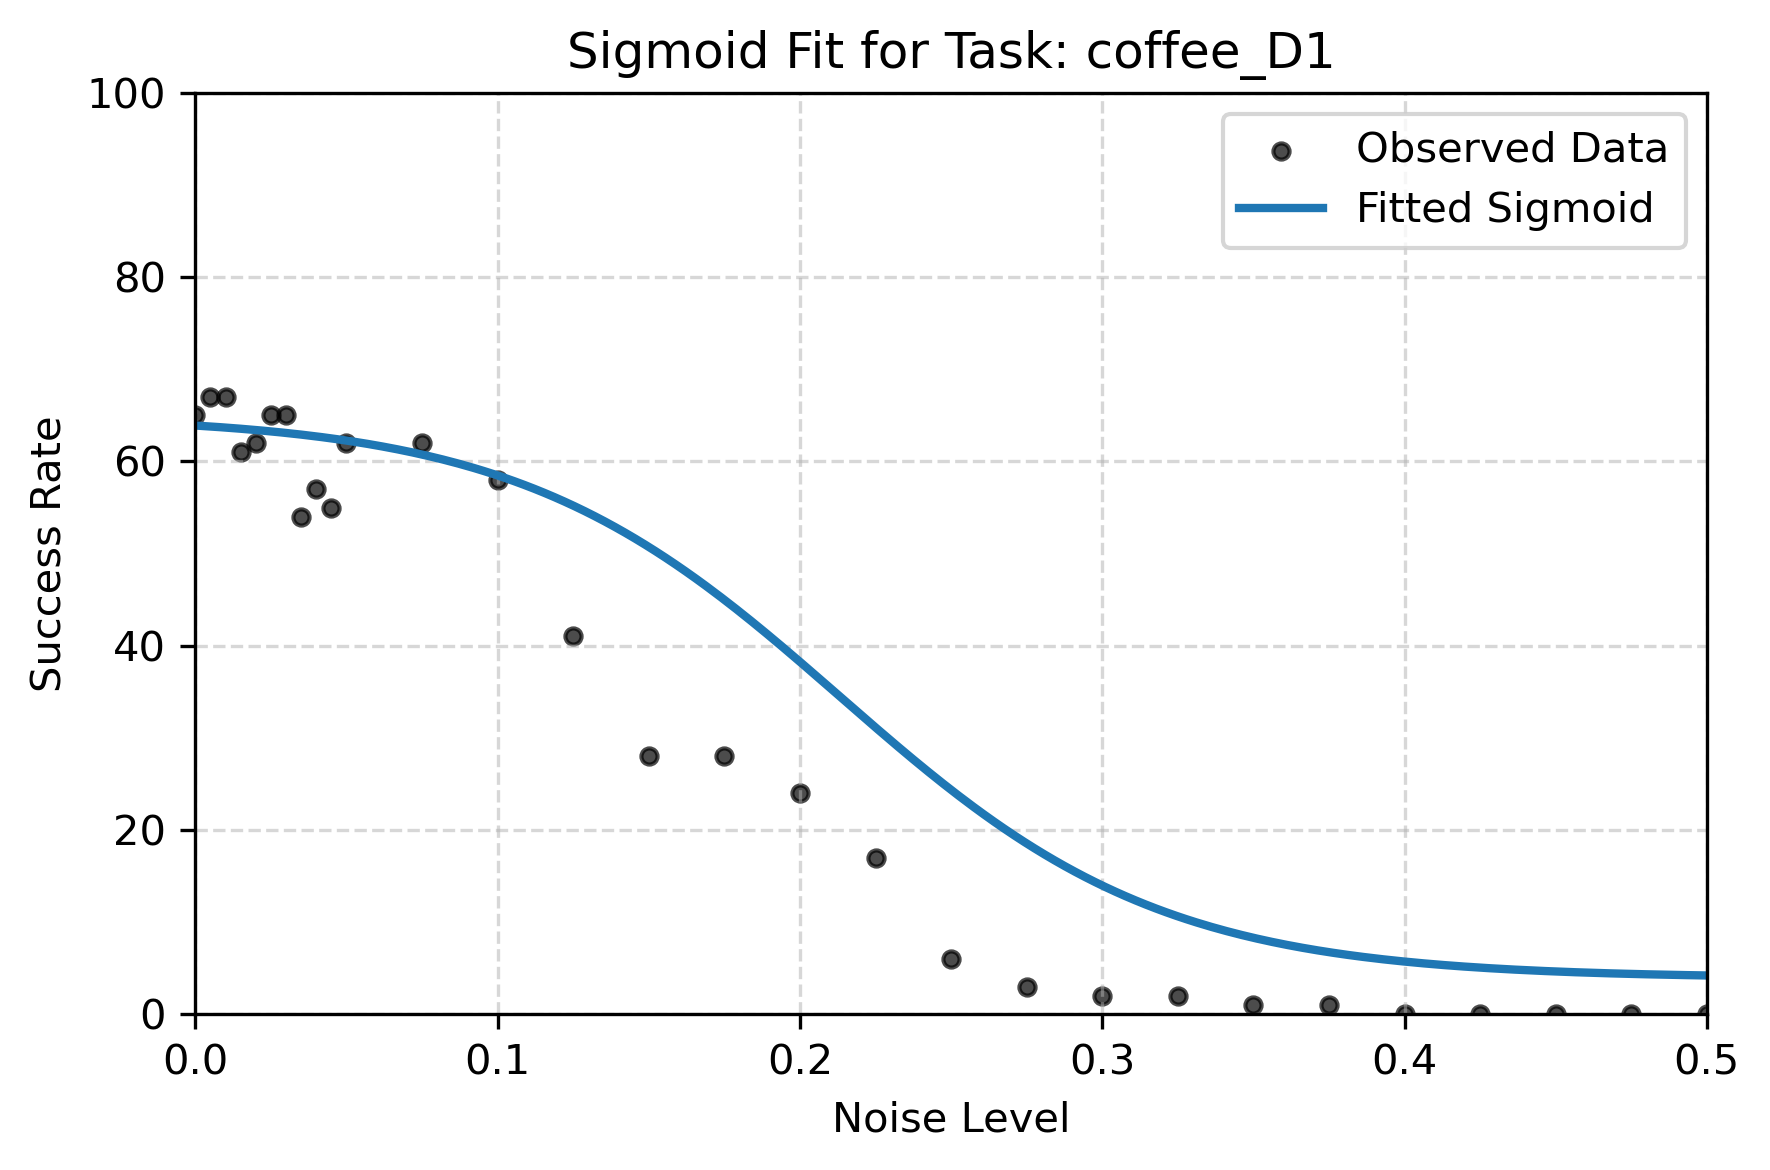

Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P
SSE: 926.4037320594841


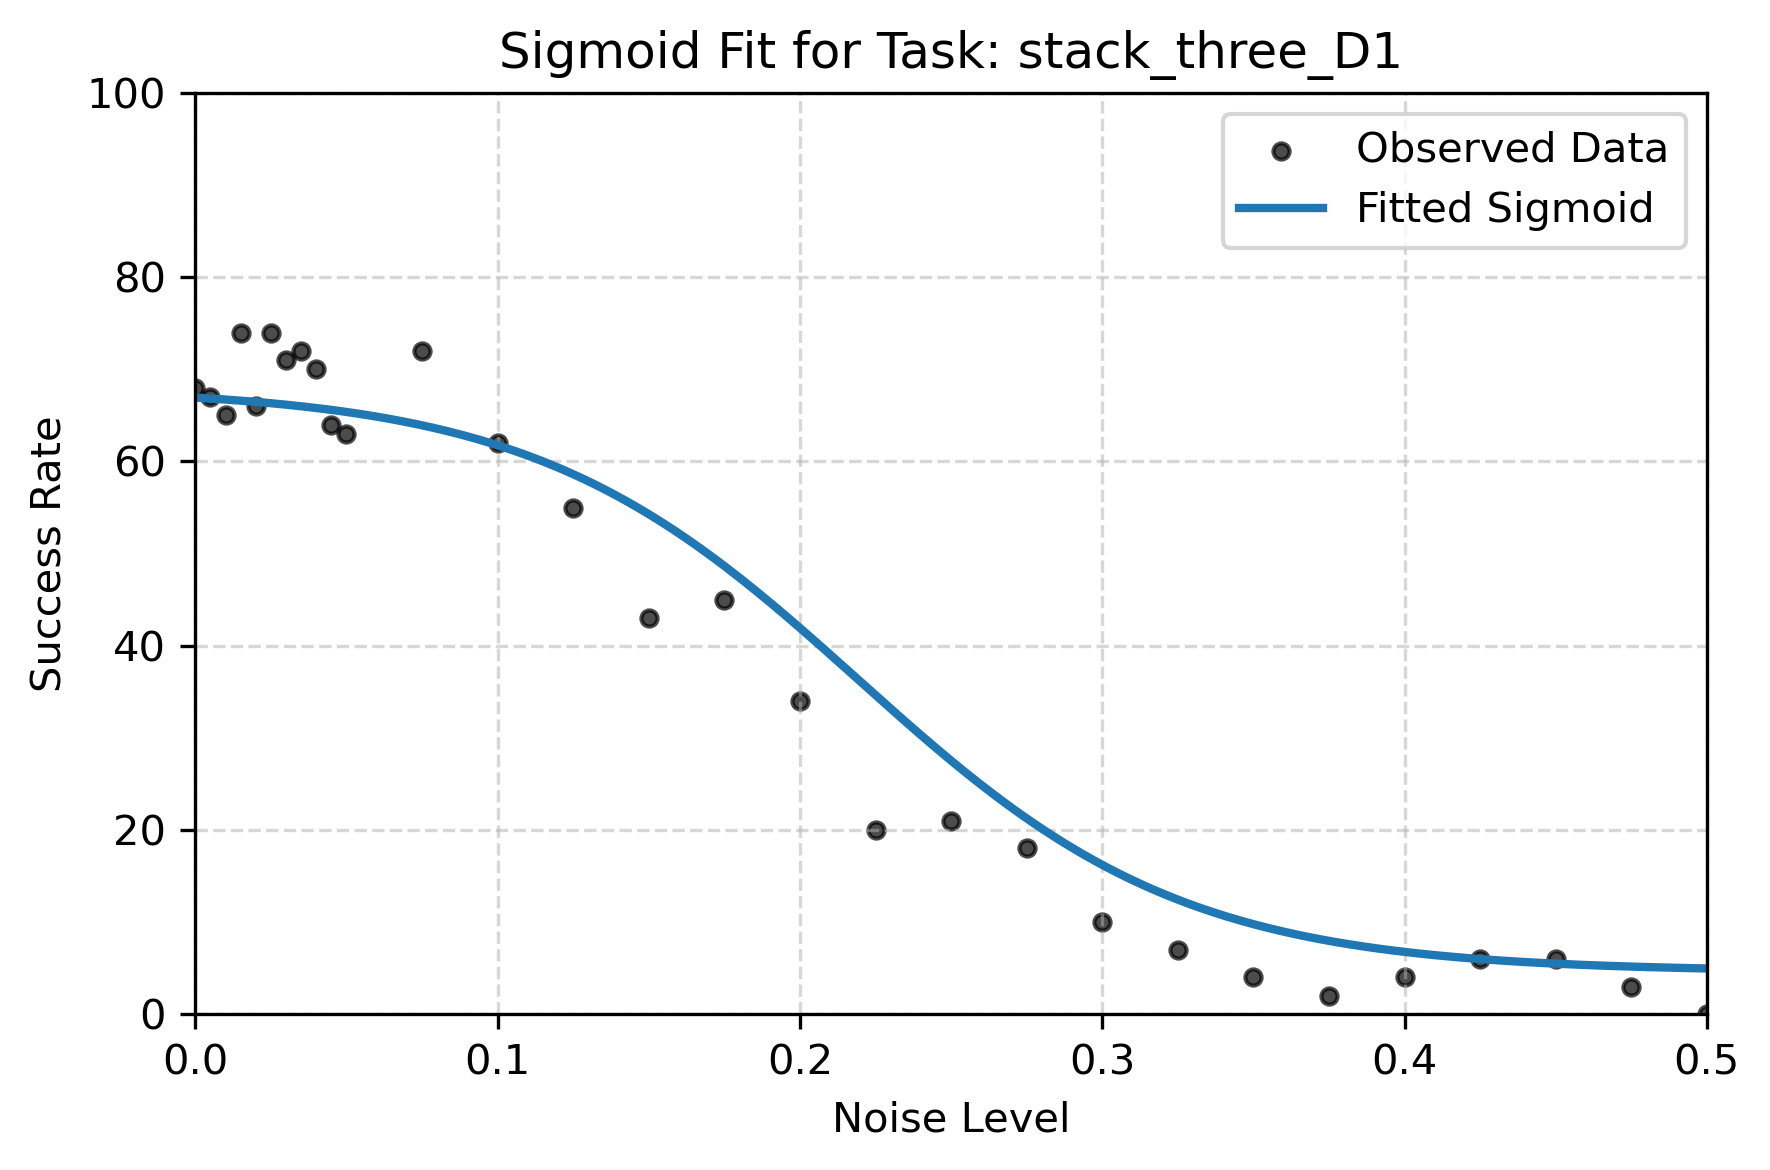

Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P
SSE: 5162.426577810746


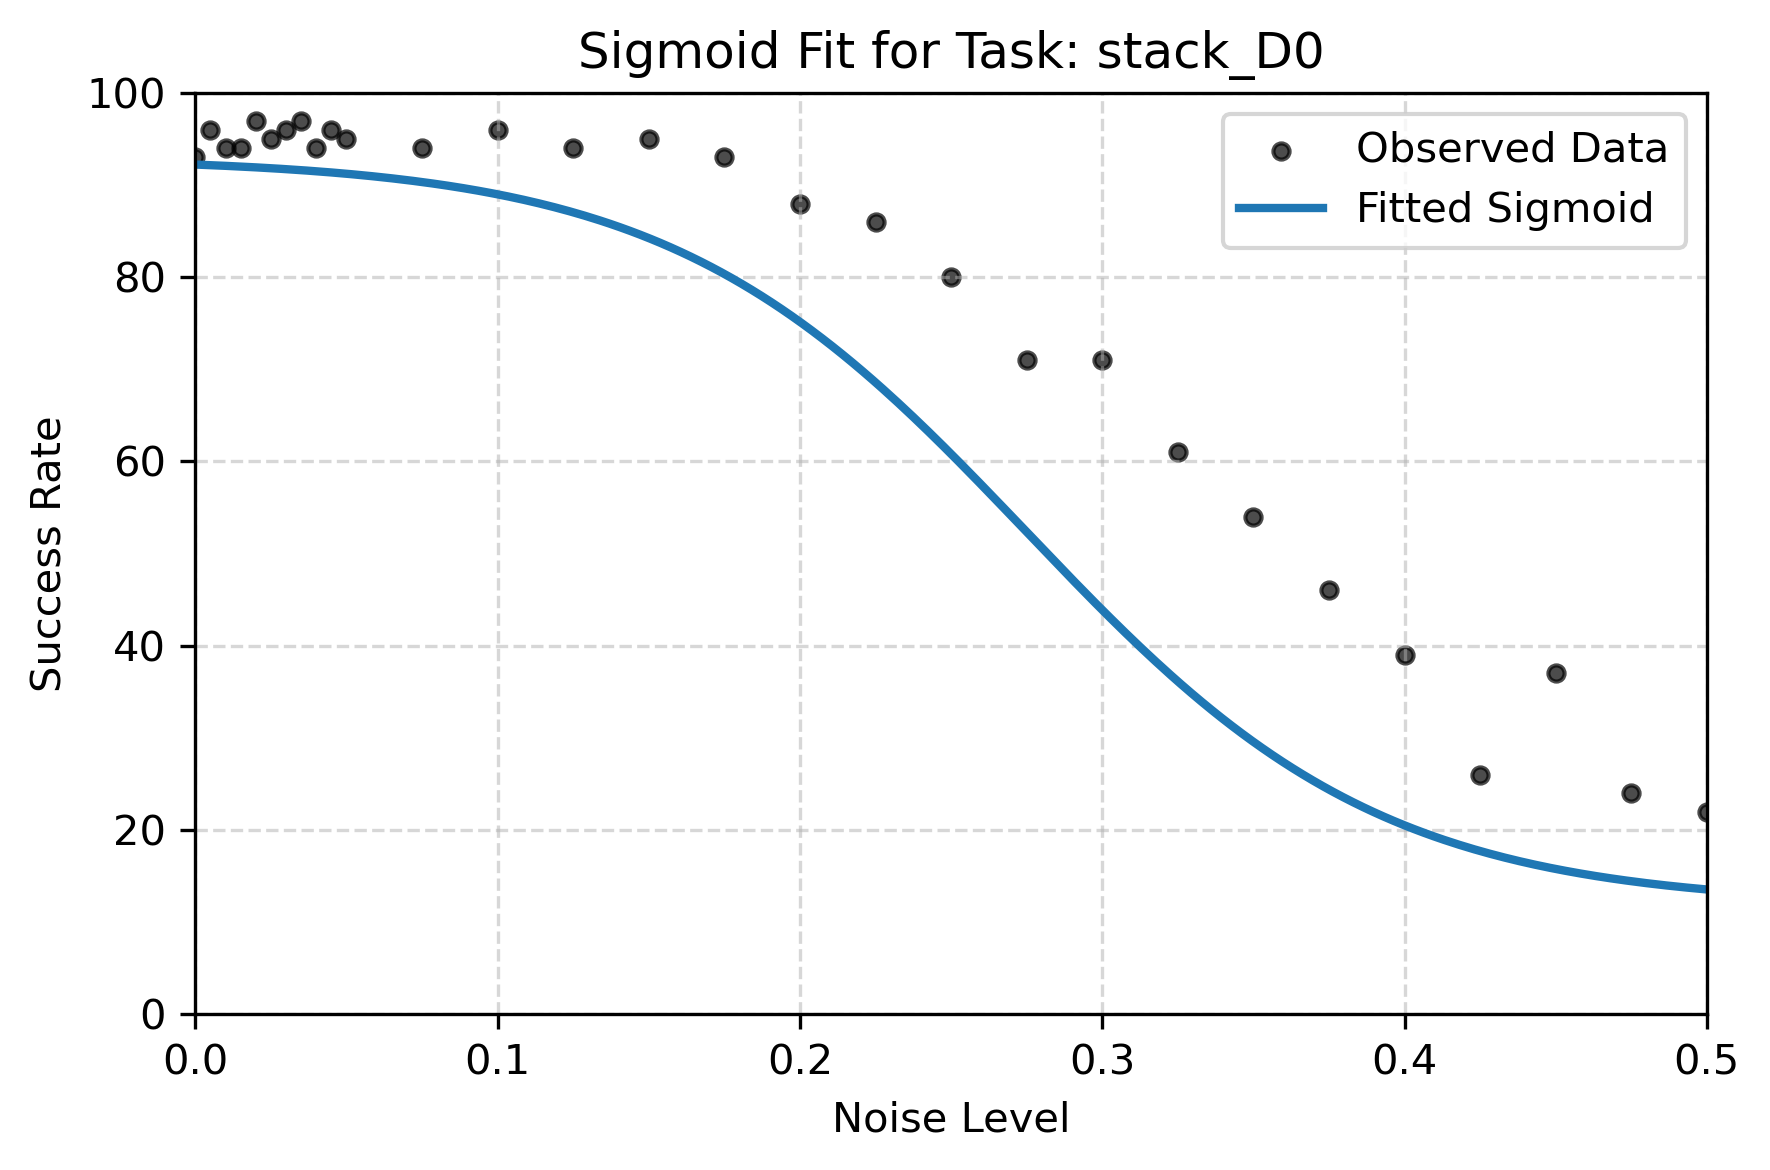

Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P
SSE: 1252.0661674493704


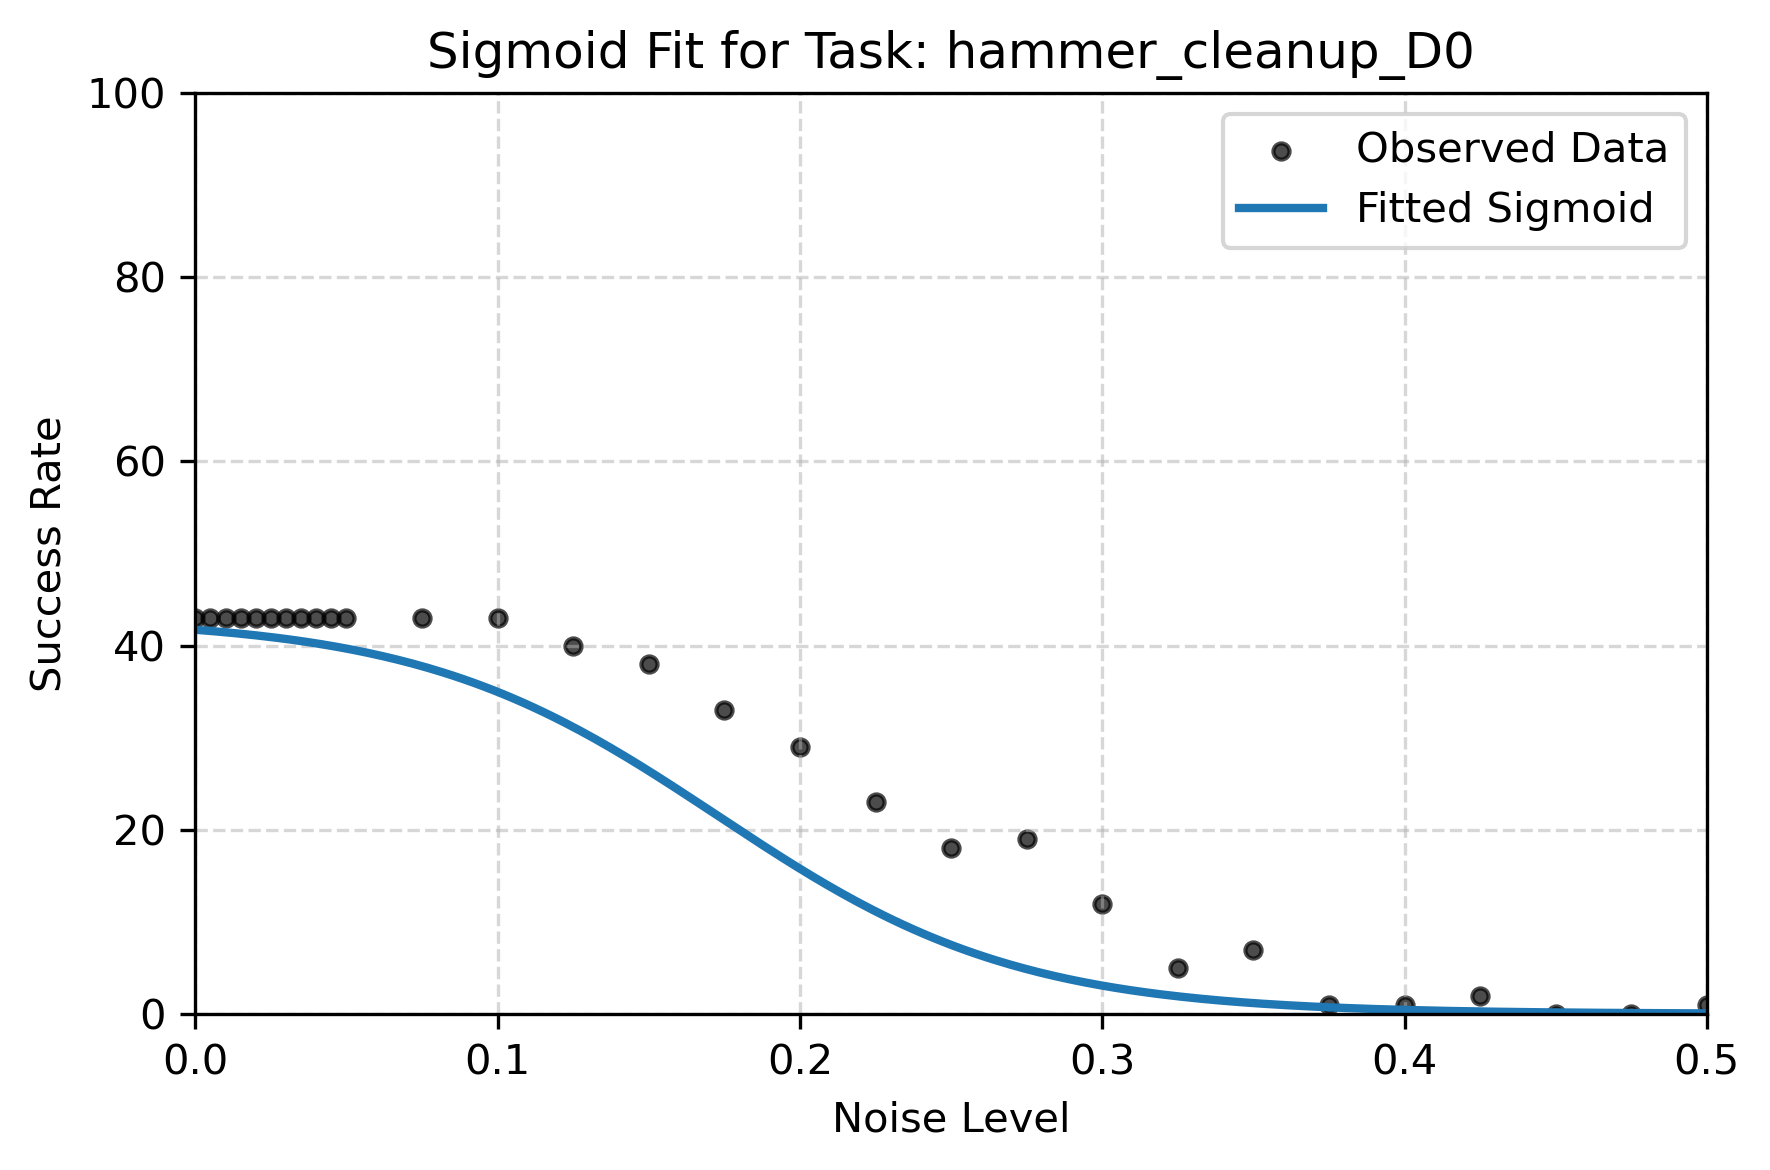

Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P
SSE: 748.5864525838123


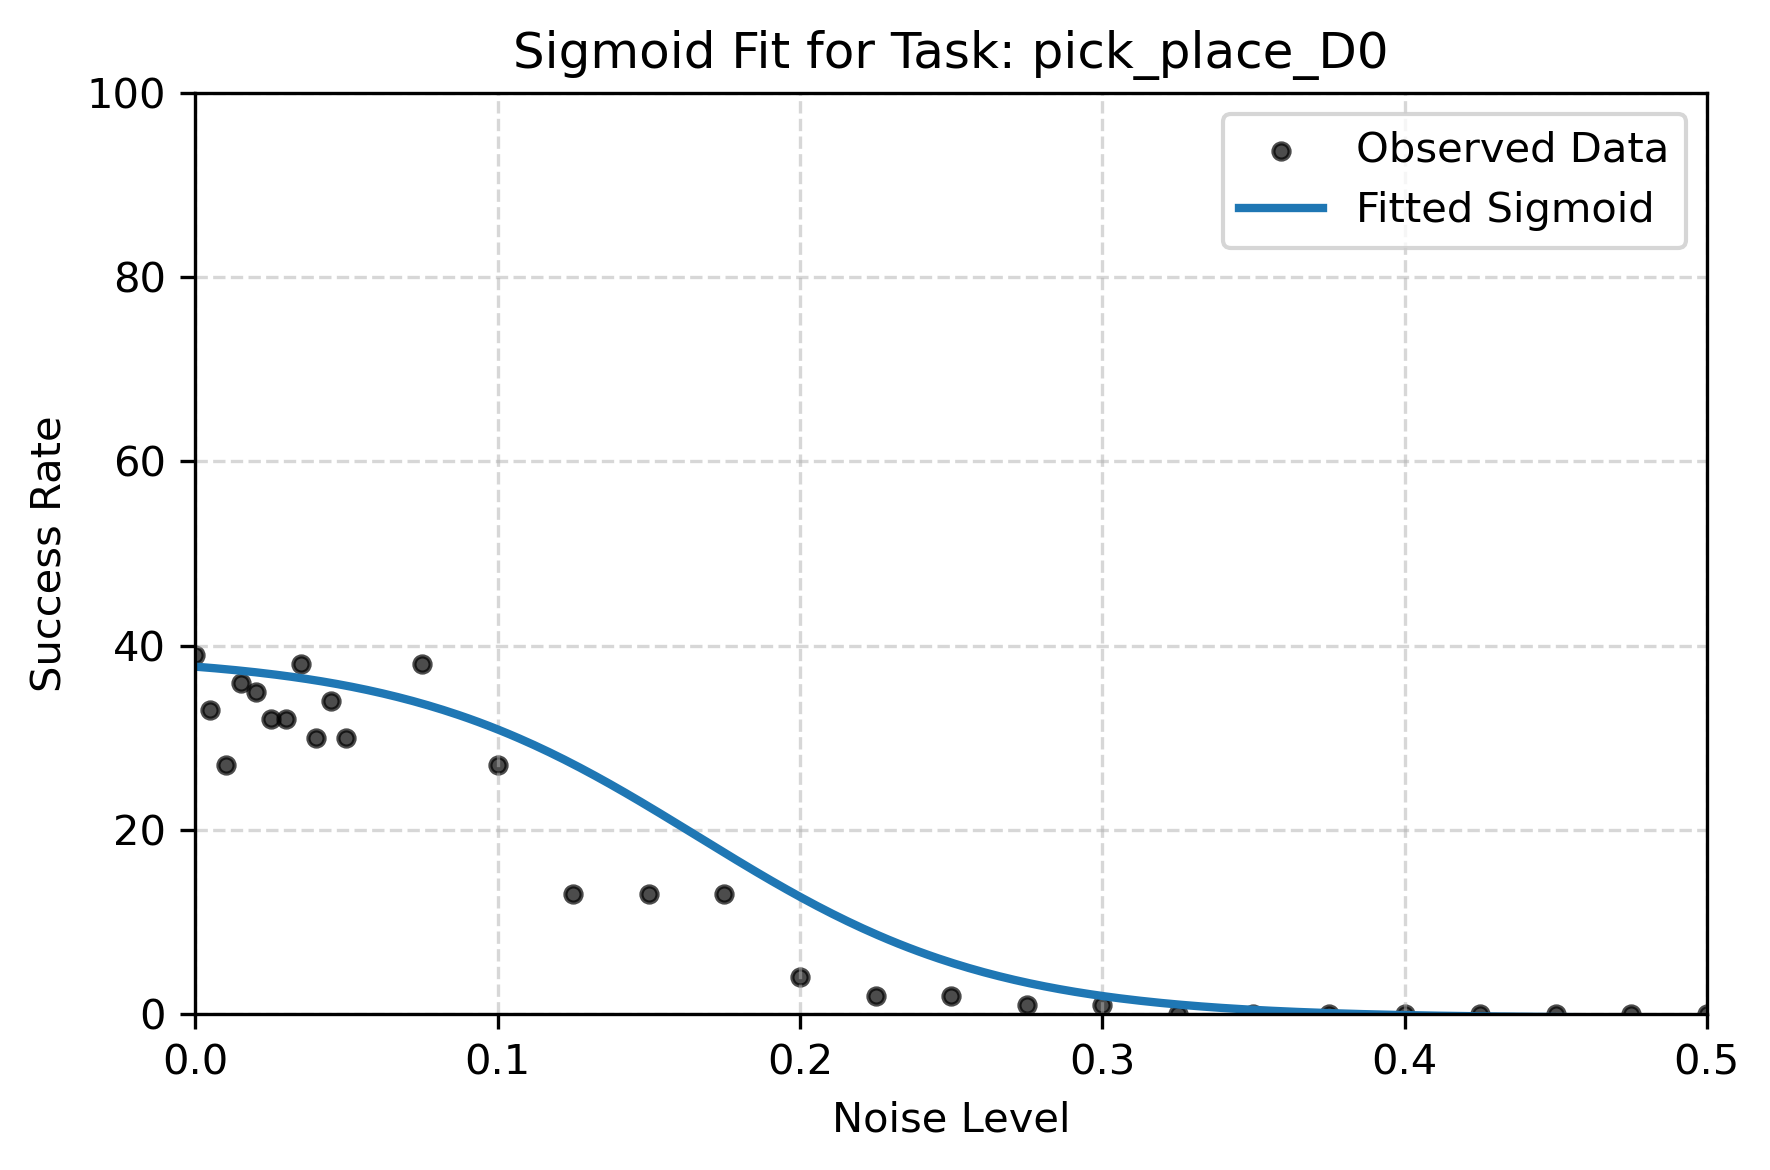

Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P
SSE: 517.9539636209798


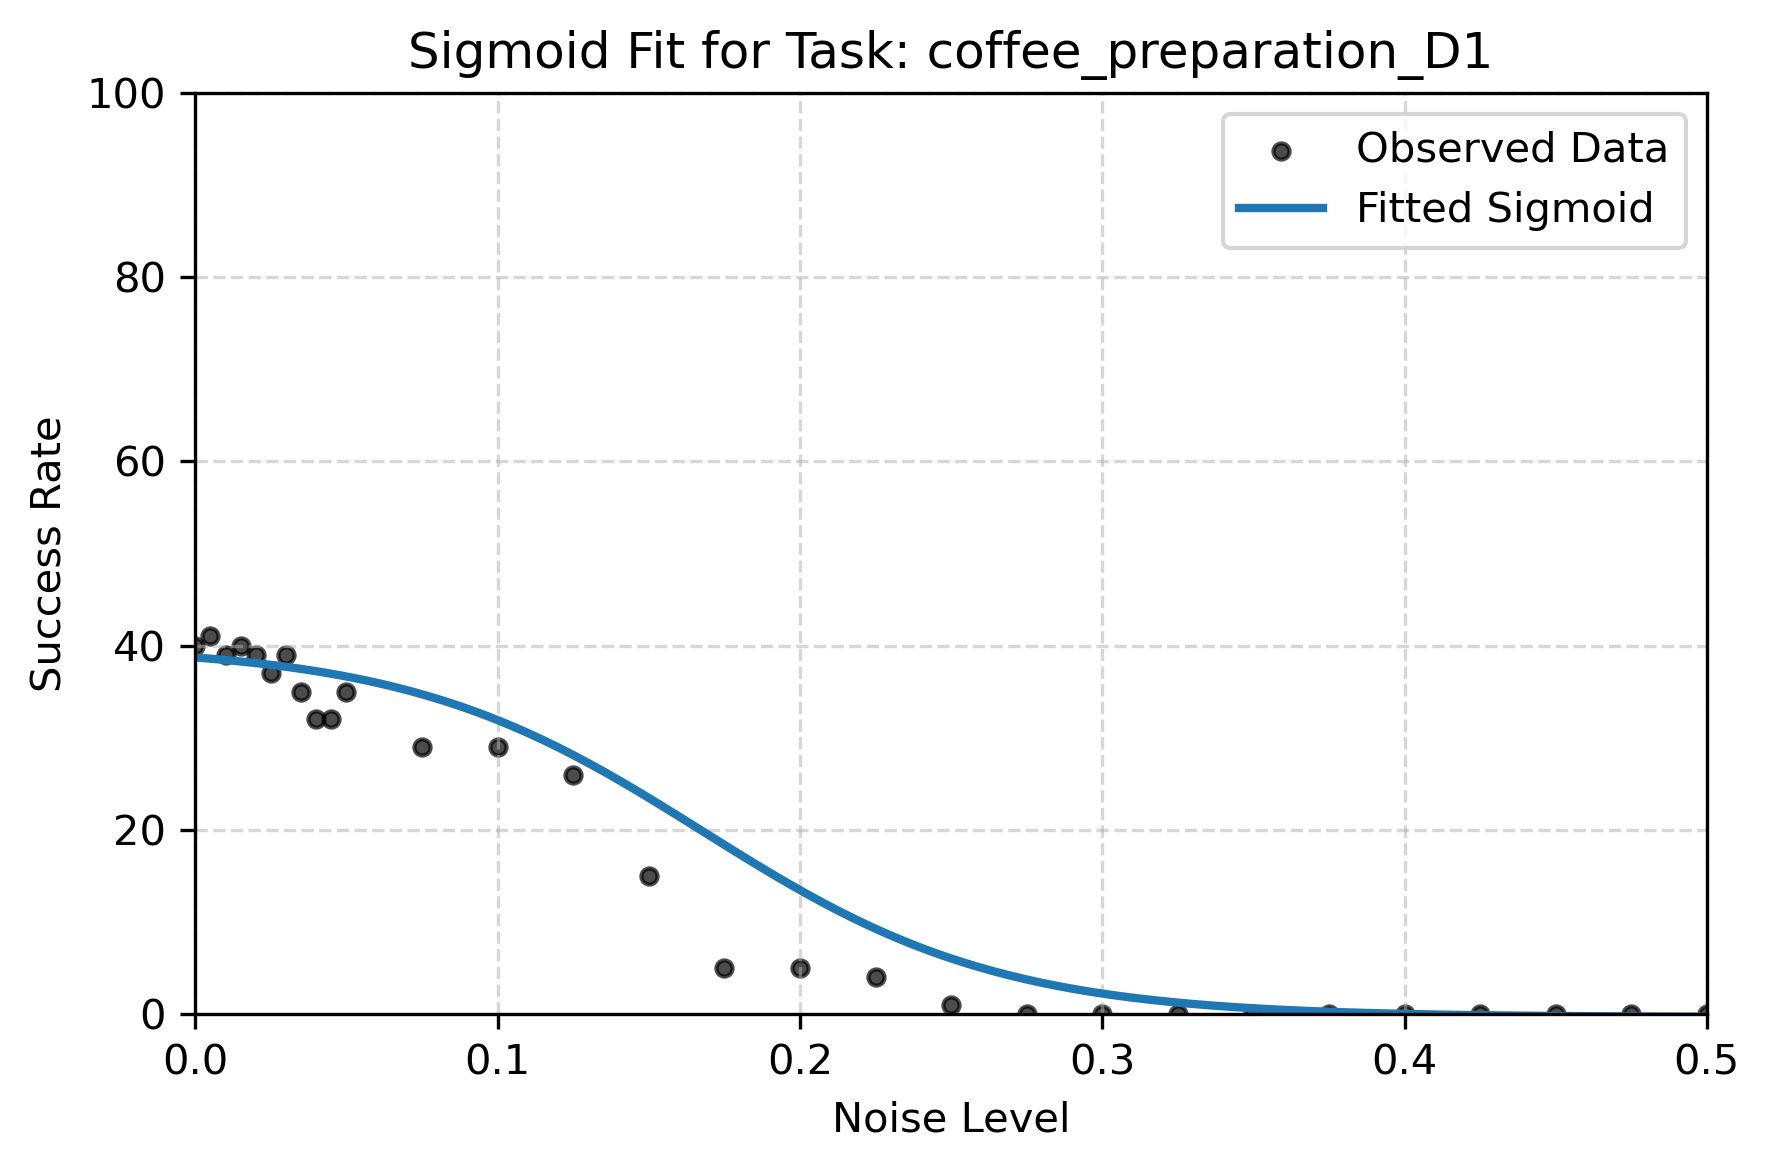

Fitted parameter models:
B(P) = 0.8766 + 0.0029 * P
C(P) = 22.9877 + -0.0652 * P
E(P) = -2.3768 + -0.0259 * P
SSE: 104.55382890208621


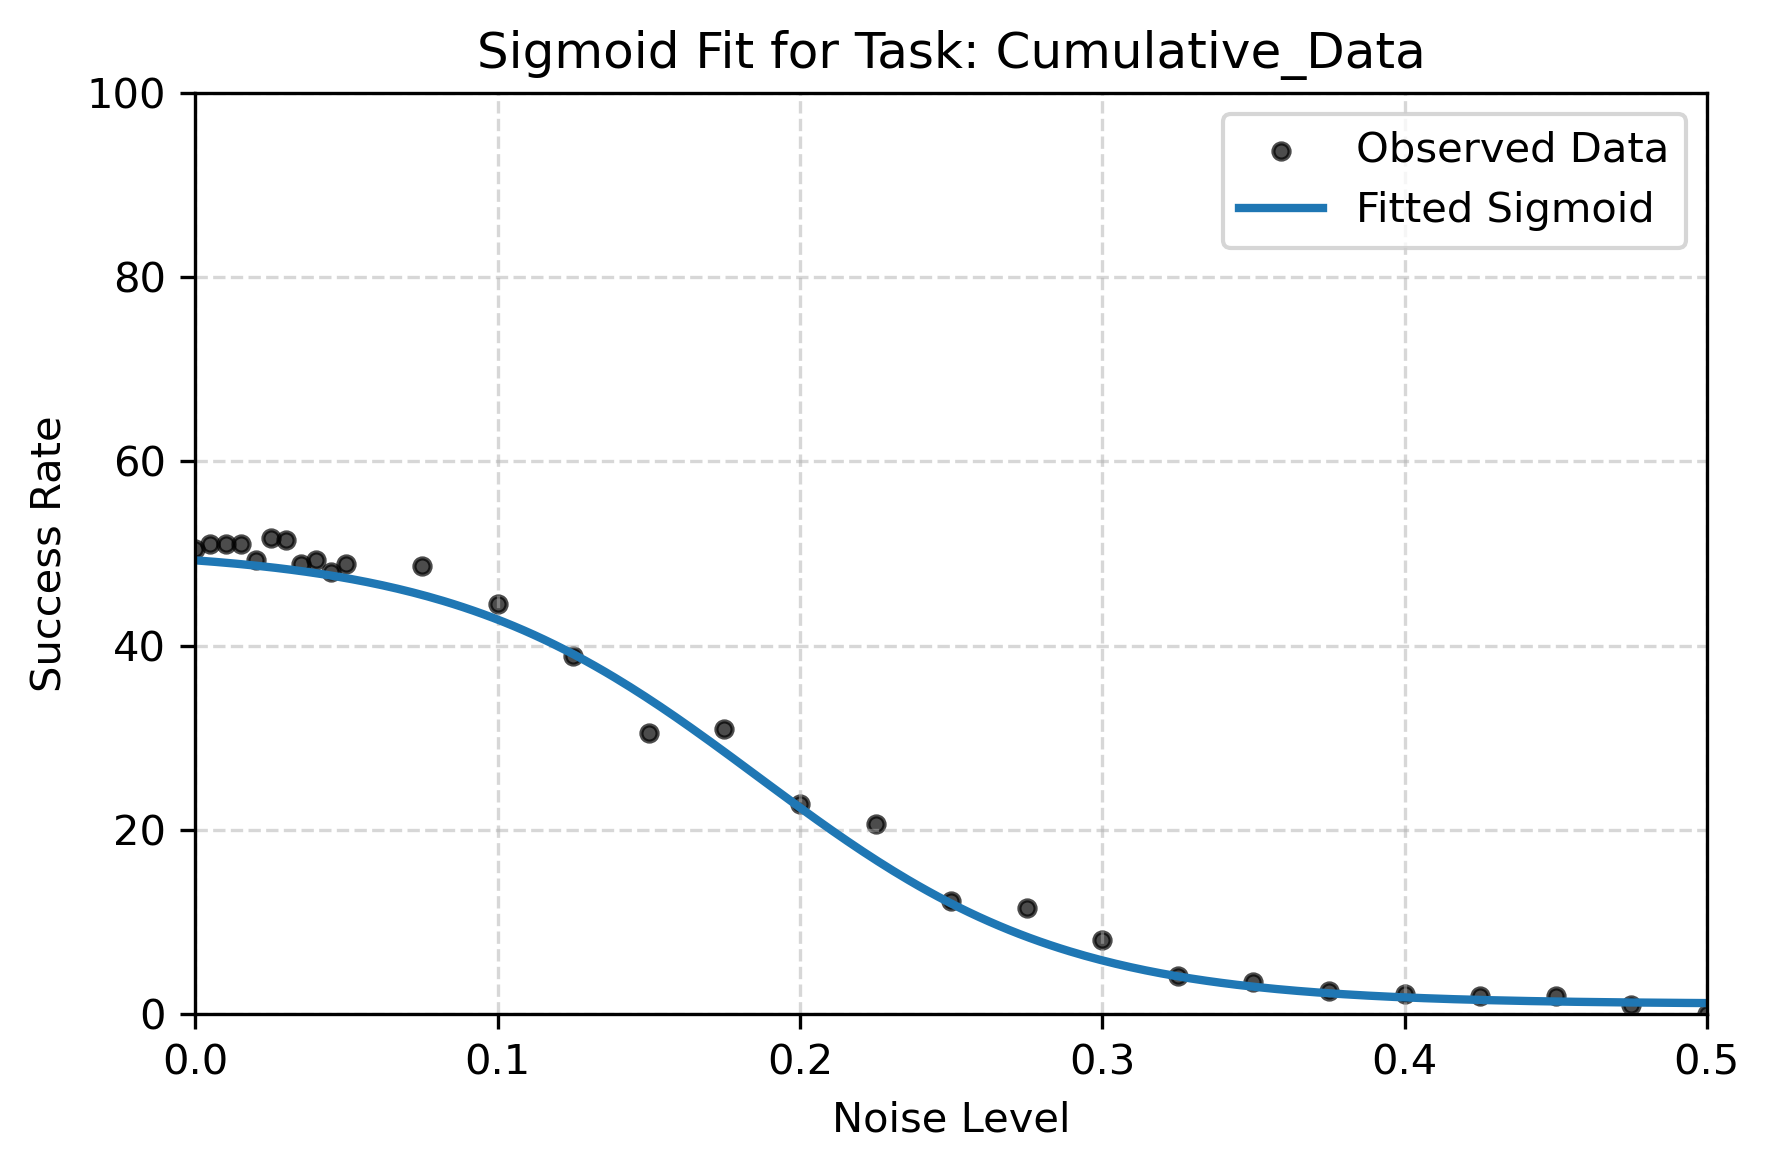

In [ ]:
for task in tasks:
    data_dir = os.path.expanduser("~/MimicGenProject/MimicGenProject/data")
    output_csv = os.path.join(data_dir, f"{task}.csv")
    data = pd.read_csv(output_csv)
    data = data[data["noise"] < 1.0]

    # Your data
    x_data = data["noise"].to_numpy()
    y_data = data["success_rate"].to_numpy() if task != "Cumulative_Data" else data["avg accuracy"].to_numpy()

    P = y_data[0]

    # Your sigmoid function
    custom_sigmoid = fit_parameter_models(learned_parameters)

    # print(f"Parameters for task {task}: {str(params_opt)}")
    # print(f"Performance with 0 noise: {y_data[0]}")
    SSE = np.sum((y_data - custom_sigmoid(x_data, P))**2)
    print(f"SSE: {SSE}")
    # Put the SSE in the summary_statistics DataFrame
    summary_statistics.loc[task, 'SSE2'] = SSE
    # Add RMSE and MAE to summary_statistics
    RMSE = np.sqrt(SSE / len(x_data))
    MAE = np.mean(np.abs(y_data - custom_sigmoid(x_data, P)))
    summary_statistics.loc[task, 'RMSE2'] = RMSE
    summary_statistics.loc[task, 'MAE2'] = MAE
    # Add R^2 to summary_statistics
    y_mean = np.mean(y_data)
    SS_total = np.sum((y_data - y_mean)**2)
    SS_residual = np.sum((y_data - custom_sigmoid(x_data, P))**2)
    R_squared = 1 - (SS_residual / SS_total)
    summary_statistics.loc[task, 'R_squared2'] = R_squared
    
    # Plot
    plt.figure(figsize=(6, 4), dpi=300)
    plt.scatter(x_data, y_data, label='Observed Data', color='black', s=15, alpha=0.7)

    x_fit = np.linspace(min(x_data), max(x_data), 300)
    y_fit = custom_sigmoid(x_fit, P)
    plt.plot(x_fit, y_fit, label='Fitted Sigmoid', linewidth=2)

    # Labels and styling
    plt.title(f"Sigmoid Fit for Task: {task}", fontsize=12)
    plt.xlabel("Noise Level", fontsize=10)
    plt.ylabel("Success Rate", fontsize=10)
    plt.ylim(0,100)
    plt.xlim(0,.5)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()

    # Optional: save figure
    # fig_path = os.path.join(data_dir, f"{task}_fit.png")
    # plt.savefig(fig_path, dpi=300)
    if SAVE_FILE:
        plt.savefig(os.path.join(data_dir, f"charts/approx_sigmoid/{task}_fit.png"), dpi=300)
    plt.show()

In [36]:
statistics = summary_statistics.copy()
trial_count = 30
# Display summary statistics
print("Summary Statistics:")
print(statistics)

Summary Statistics:
                               SSE1         SSE2     RMSE1      MAE1  \
square_D1                267.622802  1778.075138  3.037824  2.366566   
nut_assembly_D0          279.670012   380.510182  3.105446  2.304336   
three_piece_assembly_D1  145.067728   689.542170  2.236590  1.702745   
kitchen_D1               361.906033   425.109334  3.532636  2.373988   
coffee_D1                354.325808  2615.043127  3.495444  2.602976   
stack_three_D1           336.957914   926.403732  3.408700  2.873784   
stack_D0                 183.951226  5162.426578  2.518560  1.704060   
hammer_cleanup_D0         51.384912  1252.066167  1.331125  0.987178   
pick_place_D0            264.116067   748.586453  3.017855  1.967556   
coffee_preparation_D1    113.672166   517.953964  1.979831  1.372731   
Cumulative_Data           48.070585   104.553829  1.287481  0.969192   

                         R_squared1      RMSE2       MAE2  R_squared2  
square_D1                  0.963045   7.830